# Прогнозирование оттока клиентов (сеть отелей)

## Описание проекта
Заказчик данного исследования — сеть отелей «Как в гостях». 
Чтобы привлечь клиентов, указанная сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, разработаем систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту будет предлагаться внести депозит в размере заданной доли (в исследовании принято 80%) от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Основная бизнес-метрика для сети отелей — прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Шаг 1. Загрузка файлов с данными

In [1]:
# В проекте будем решать задачу классификации. Загрузим библиотеки, которые будут использоваться
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate # Для поведения кросс-валидации
# Для масштабирования и прямого кодирования признаков
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)    
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score,       # Расчёт AUC ROC
    roc_curve,           # Построение ROC-кривой
    confusion_matrix     # Вычисление tn, fp, fn, tp
)

# Константы
RANDOM_STATE = 12345 # для random_state
PRICE_A = 1000 # Стоимость номеров отеля категория A за ночь
SERVICE_A = 400 # Стоимость разового обслуживания номеров отеля категория A
PRICE_B = 800 # Стоимость номеров отеля категория B за ночь
SERVICE_B = 350 # Стоимость разового обслуживания номеров отеля категория B
PRICE_C = 600 # Стоимость номеров отеля категория C за ночь
SERVICE_C = 350 # Стоимость разового обслуживания номеров отеля категория C
PRICE_D = 550 # Стоимость номеров отеля категория D за ночь
SERVICE_D = 150 # Стоимость разового обслуживания номеров отеля категория D
PRICE_E = 500 # Стоимость номеров отеля категория E за ночь
SERVICE_E = 150 # Стоимость разового обслуживания номеров отеля категория E
PRICE_F = 450 # Стоимость номеров отеля категория F за ночь
SERVICE_F = 150 # Стоимость разового обслуживания номеров отеля категория F
PRICE_G = 350 # Стоимость номеров отеля категория G за ночь
SERVICE_G = 150 # Стоимость разового обслуживания номеров отеля категория G
SUMMER_FACTOR = 1.4 # Сезонный коэффициент для лета: цены повышаются на 40%
FALL_SPRING_FACTOR = 1.2 # Сезонный коэффициент для весны и осени: цены повышаются на 20%
DEPOSIT = 0.8 # Размер депозита для заказчиков, которые могут отменить бронь
BUDGET = 400000 # Бюджет на разработку системы прогнозирования

In [2]:
# Загрузим данные из файлов
try:
    df_train = pd.read_csv('hotel_train.csv')
    df_test = pd.read_csv('hotel_test.csv')
except:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')

In [3]:
# Рассмотрим первые строки
print('df_train')
display(df_train.head())
print('df_test')
df_test.head()

df_train


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


df_test


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы.
Каждый объект в наборе данных — это информация о бронировании. Столбцы содержат следующую информацию (признаки):
- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

## Шаг 2. Предобработка и исследовательский анализ данных

### Типы, пропуски, дубликаты

In [4]:
# Изучим информацию о данных df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
# Изучим информацию о данных df_test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Типы данных в столбцах `lead_time`, `adults`, `children`, `babies` изменим на `int`, так как в указанных столбцах содержится целочисленная информация.

In [6]:
# Изменим тип данных
df_train[['lead_time', 'adults', 'children', 'babies']] = \
df_train[['lead_time', 'adults', 'children', 'babies']].astype('int64')
df_test[['lead_time', 'adults', 'children', 'babies']] = \
df_test[['lead_time', 'adults', 'children', 'babies']].astype('int64')

In [7]:
# Посчитаем пропуски (убедимся, что пропуски в данных отсутствуют). 
display(df_train.isna().sum()/df_train.shape[0])
df_test.isna().sum()/df_test.shape[0]

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

In [8]:
# Проверим наличие дубликатов по столбцу id в df_train
df_train['id'].duplicated().sum()

0

In [9]:
# Проверим наличие дубликатов по столбцу id в df_test
df_train['id'].duplicated().sum()

0

In [10]:
# Удалим признак `id`, так как он не даёт информации с точки зрения целевого признака
# Проверим отсутствие полных дубликатов без `id`
train = df_train.drop('id', axis=1).copy()
test = df_test.drop('id', axis=1).copy()
print('Дубликатов в обучающей выборке: ', train.duplicated(keep='first').sum(), ', или ',
      round(100*train.duplicated(keep='first').sum()/train.shape[0], 2), '%', sep='')
print('Дубликатов в тестовой выборке: ', test.duplicated(keep='first').sum(), ', или ',
      round(100*test.duplicated(keep='first').sum()/test.shape[0], 2), '%', sep='')

Дубликатов в обучающей выборке: 21377, или 32.77%
Дубликатов в тестовой выборке: 7717, или 23.81%


In [11]:
# Избавимся от полных дубликатов
train = train.drop_duplicates()
test = test.drop_duplicates()

In [12]:
# Проверим результат train
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43852 entries, 0 to 65228
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     43852 non-null  int64 
 1   lead_time                       43852 non-null  int64 
 2   arrival_date_year               43852 non-null  int64 
 3   arrival_date_month              43852 non-null  object
 4   arrival_date_week_number        43852 non-null  int64 
 5   arrival_date_day_of_month       43852 non-null  int64 
 6   stays_in_weekend_nights         43852 non-null  int64 
 7   stays_in_week_nights            43852 non-null  int64 
 8   adults                          43852 non-null  int64 
 9   children                        43852 non-null  int64 
 10  babies                          43852 non-null  int64 
 11  meal                            43852 non-null  object
 12  country                         43852 non-null

In [13]:
# Проверим результат df_test
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24695 entries, 0 to 32411
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     24695 non-null  int64 
 1   lead_time                       24695 non-null  int64 
 2   arrival_date_year               24695 non-null  int64 
 3   arrival_date_month              24695 non-null  object
 4   arrival_date_week_number        24695 non-null  int64 
 5   arrival_date_day_of_month       24695 non-null  int64 
 6   stays_in_weekend_nights         24695 non-null  int64 
 7   stays_in_week_nights            24695 non-null  int64 
 8   adults                          24695 non-null  int64 
 9   children                        24695 non-null  int64 
 10  babies                          24695 non-null  int64 
 11  meal                            24695 non-null  object
 12  country                         24695 non-null

Вывод: пропуски и дубликаты в данных отсутствуют, типы данных приведены в соответствие со значениями в столбцах. Перейдём к исследованию данных в столбцах.

### Анализ признаков

#### Целевой признак

Исследуем целевой признак `is_canceled`

In [14]:
display(train['is_canceled'].value_counts())
train['is_canceled'].mean()

0    32704
1    11148
Name: is_canceled, dtype: int64

0.25421873574751436

In [15]:
display(test['is_canceled'].value_counts())
test['is_canceled'].mean()

0    16910
1     7785
Name: is_canceled, dtype: int64

0.3152460012148208

In [16]:
df_train['is_canceled']

0        0
1        0
2        0
3        0
4        1
        ..
65224    0
65225    0
65226    0
65227    0
65228    0
Name: is_canceled, Length: 65229, dtype: int64

Аномальные значения отсутствуют. В выборках преимущественно представлены объекты с нулевым значением целевого признака, соотношение ~70..75/30..25, при этом в тренировочной и тестовой выборках баланс приблизительно одинаковый. 

#### Количество постояльцев

Исследуем признаки, связанные с количеством постояльцев:
- `adults` — количество взрослых постояльцев,
- `babies` — количество младенцев,
- `children` — количество детей от 3 до 14 лет.

А также добавим к указанным признакам ещё два: `total_children`, `total_guests` - суммарное количество детей, суммарное количество постояльцев соответственно.

In [17]:
# Определим функцию, которая позволяет из переданных ей двух датасетов и имени признака
# скомпоновать информативную таблицу с распределением значений признака в датасетах
def feature_count(train, test, feat_name):
    result = train[feat_name].value_counts().reset_index().merge(
         train[feat_name].value_counts(normalize=True).reset_index(),
         how='outer', left_on='index', right_on='index').merge(
         test[feat_name].value_counts().reset_index().merge(
         test[feat_name].value_counts(normalize=True).reset_index(),
         how='outer', left_on='index', right_on='index'),
         how='outer', left_on='index', right_on='index').fillna('')
    result.columns = ['Значение '+ feat_name, 'Частота в train', 'Доля в train',
                 'Частота в test', 'Доля в test']
    return result

In [18]:
# Добавим признак с суммарным количеством детей
train['total_children'] = train['babies'] + train['children']
test['total_children'] = test['babies'] + test['children']

# Добавим признак с суммарным количеством постояльцев
train['total_guests'] = train['adults'] + train['babies'] + train['children']
test['total_guests'] = test['adults'] + test['babies'] + test['children']

# Посмотрим, как представлены значения признаков в имеющихся данных
print('Количество взрослых постояльцев')
display(feature_count(train, test, 'adults'))

print('Количество младенцев')
display(feature_count(train, test, 'babies'))

print('Количество детей от 3 до 14 лет')
display(feature_count(train, test, 'children'))

print('Суммарное количество детей')
display(feature_count(train, test, 'total_children'))

print('Общее количество постояльцев')
feature_count(train, test, 'total_guests')

Количество взрослых постояльцев


,Значение adults,Частота в train,Доля в train,Частота в test,Доля в test
0,2,32299,0.736546,18536,0.750597
1,1,8688,0.198121,4378,0.177283
2,3,2688,0.061297,1708,0.069164
3,0,164,0.003740,65,0.002632
4,4,13,0.000296,8,0.000324


Количество младенцев


,Значение babies,Частота в train,Доля в train,Частота в test,Доля в test
0,0,43403,0.989761,24521.0,0.992954
1,1,444,0.010125,170.0,0.006884
2,2,3,0.000068,4.0,0.000162
3,9,1,0.000023,,
4,10,1,0.000023,,


Количество детей от 3 до 14 лет


,Значение children,Частота в train,Доля в train,Частота в test,Доля в test
0,0,40471,0.922900,22727,0.920308
1,1,2060,0.046976,1322,0.053533
2,2,1305,0.029759,641,0.025957
3,3,16,0.000365,5,0.000202


Суммарное количество детей


,Значение total_children,Частота в train,Доля в train,Частота в test,Доля в test
0,0,40084,0.914075,22586.0,0.914598
1,1,2393,0.054570,1429.0,0.057866
2,2,1344,0.030649,672.0,0.027212
3,3,29,0.000661,8.0,0.000324
4,9,1,0.000023,,
5,10,1,0.000023,,


Общее количество постояльцев


,Значение total_guests,Частота в train,Доля в train,Частота в test,Доля в test
0,2,29164,0.665055,16809.0,0.680664
1,1,8504,0.193925,4239.0,0.171654
2,3,4950,0.112880,3023.0,0.122413
3,4,1200,0.027365,608.0,0.02462
4,5,17,0.000388,9.0,0.000364
5,0,15,0.000342,7.0,0.000283
6,10,1,0.000023,,
7,12,1,0.000023,,


В данных имеются значения, которые требуют дополнительной обработки:
- уберём строки, в которых количество младенцев 9-10 (соответственно суммарное количество постояльцев 10-12),
- уберём строки, в которых суммарное количество постояльцев 0,
- проверим, нет ли в строках без взрослых младенцев или детей, и если такие строки есть, то удалим их.

In [19]:
print(train[(train['adults']==0)&(train['total_children']!=0)]['adults'].count())
print(test[(test['adults']==0)&(test['total_children']!=0)]['adults'].count())

149
58


In [20]:
# Уберём аномальные данные
train = train.loc[(train['total_children'] < 9)&(train['total_guests'] != 0)&\
                  ~((train['adults']==0)&(train['total_children']!=0)), :].copy()
test = test.loc[(test['total_children'] < 9)&(test['total_guests'] != 0)&\
                ~((test['adults']==0)&(test['total_children']!=0)), :].copy()
# Посмотрим результат
print('Количество взрослых постояльцев')
display(feature_count(train, test, 'adults'))

print('Количество младенцев')
display(feature_count(train, test, 'babies'))

print('Количество детей от 3 до 14 лет')
display(feature_count(train, test, 'children'))

print('Суммарное количество детей')
display(feature_count(train, test, 'total_children'))

print('Общее количество постояльцев')
feature_count(train, test, 'total_guests')

Количество взрослых постояльцев


,Значение adults,Частота в train,Доля в train,Частота в test,Доля в test
0,2,32298,0.739322,18536,0.752578
1,1,8687,0.198851,4378,0.177751
2,3,2688,0.061530,1708,0.069346
3,4,13,0.000298,8,0.000325


Количество младенцев


,Значение babies,Частота в train,Доля в train,Частота в test,Доля в test
0,0,43242,0.989837,24456,0.992935
1,1,441,0.010095,170,0.006902
2,2,3,0.000069,4,0.000162


Количество детей от 3 до 14 лет


,Значение children,Частота в train,Доля в train,Частота в test,Доля в test
0,0,40454,0.926017,22720,0.922452
1,1,2058,0.047109,1320,0.053593
2,2,1166,0.026690,587,0.023833
3,3,8,0.000183,3,0.000122


Суммарное количество детей


,Значение total_children,Частота в train,Доля в train,Частота в test,Доля в test
0,0,40069,0.917205,22579,0.916728
1,1,2391,0.054731,1427,0.057937
2,2,1208,0.027652,618,0.025091
3,3,18,0.000412,6,0.000244


Общее количество постояльцев


,Значение total_guests,Частота в train,Доля в train,Частота в test,Доля в test
0,2,29028,0.664469,16755,0.680268
1,1,8502,0.194616,4237,0.172026
2,3,4939,0.113057,3021,0.122655
3,4,1200,0.027469,608,0.024685
4,5,17,0.000389,9,0.000365


In [21]:
# количество младенцев можно преобразовать в категориальный признак has_babies, для которого будет значение 0.
# при отсутствии младенцев и значение 1 в остальных случаях
train.loc[train['babies']==0, 'has_babies'] = 0
test.loc[test['babies']==0, 'has_babies'] = 0
train.loc[train['babies']!=0, 'has_babies'] = 1
test.loc[test['babies']!=0, 'has_babies'] = 1
train['has_babies'] = train['has_babies'].astype('int64')
test['has_babies'] = test['has_babies'].astype('int64')
train = train.drop('babies', axis=1)
test = test.drop('babies', axis=1)

# Проверим результат
display(feature_count(train, test, 'has_babies'))

,Значение has_babies,Частота в train,Доля в train,Частота в test,Доля в test
0,0,43242,0.989837,24456,0.992935
1,1,444,0.010163,174,0.007065


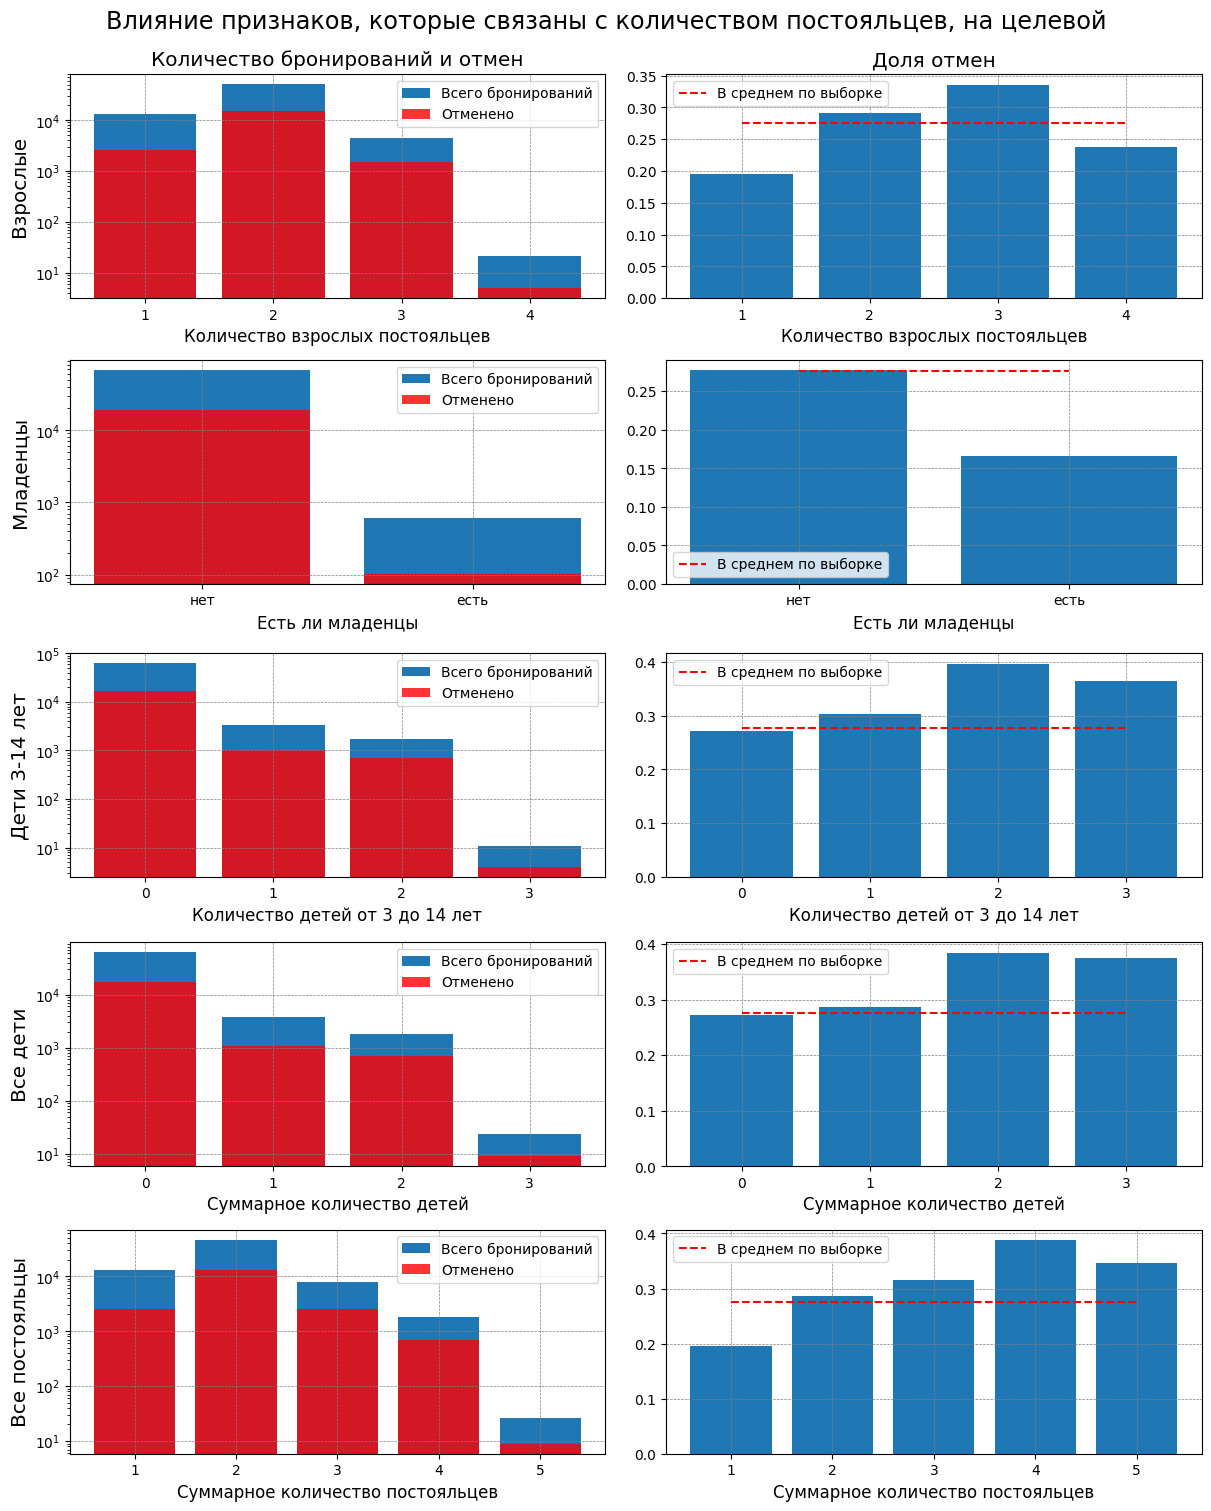

In [22]:
# Посмотрим, как зависят бронирования от рассматриваемых признаков.
# Слева построим зависимость количества бронирований и отмен от признака, а справа - доли отменённых бронирований.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(ncols=2, nrows=5,
                       figsize=(12, 15),
                       sharex=False,
                       gridspec_kw={'width_ratios': (.5, .5)},
                       constrained_layout=True)
fig.suptitle('Влияние признаков, которые связаны с количеством постояльцев, на целевой',
             fontsize='xx-large')
ax[0, 0].set_title('Количество бронирований и отмен', fontsize='x-large')
ax[0, 1].set_title('Доля отмен', fontsize='x-large')
data = pd.concat([train, test])
average = data['is_canceled'].mean()
adults_data = data.groupby(by='adults')['is_canceled'].agg(['count', 'sum', 'mean'])
babies_data = data.groupby(by='has_babies')['is_canceled'].agg(['count', 'sum', 'mean'])
children_data = data.groupby(by='children')['is_canceled'].agg(['count', 'sum', 'mean'])
total_children_data = data.groupby(by='total_children')['is_canceled'].agg(['count', 'sum', 'mean'])
total_guests_data = data.groupby(by='total_guests')['is_canceled'].agg(['count', 'sum', 'mean'])
for i in range(0,5):
    ax[i, 0].set_yscale('log')
    for j in range(0,2):
        ax[i, j].grid(color='gray', linewidth = 0.5, linestyle = '--')
        if i == 0:
            ax[i, j].set_xticks(range(0, data['adults'].max() + 1))
            ax[i, j].set_xlabel('Количество взрослых постояльцев', fontsize='large')            
        if i == 1:
            ax[i, j].set_xlabel('Есть ли младенцы', fontsize='large')
        if i == 2:
            ax[i, j].set_xticks(range(0, data['children'].max() + 1))
            ax[i, j].set_xlabel('Количество детей от 3 до 14 лет', fontsize='large')
        if i == 3:
            ax[i, j].set_xticks(range(0, data['total_children'].max() + 1))
            ax[i, j].set_xlabel('Суммарное количество детей', fontsize='large')
        if i == 4:
            ax[i, j].set_xticks(range(0, data['total_guests'].max() + 1))
            ax[i, j].set_xlabel('Суммарное количество постояльцев', fontsize='large')
            
# Построим графики для взрослых постояльцев
ax[0, 0].set_ylabel('Взрослые', fontsize='x-large')
labels = range(data['adults'].min(), data['adults'].max() + 1)
ax[0, 0].bar(labels, adults_data['count'], label='Всего бронирований')
ax[0, 0].bar(labels, adults_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[0, 0].legend()
ax[0, 1].bar(labels, adults_data['mean'])
ax[0, 1].plot([labels[0],labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[0, 1].legend()
# Построим графики для младенцев
ax[1, 0].set_ylabel('Младенцы', fontsize='x-large')
labels =['нет', 'есть']
ax[1, 0].bar(labels, babies_data['count'], label='Всего бронирований')
ax[1, 0].bar(labels, babies_data['sum'], color='red', alpha=0.8, label='Отменено')
ax[1, 0].legend()
ax[1, 1].bar(labels, babies_data['mean'])
ax[1, 1].plot([labels[0],labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[1, 1].legend()
# Построим графики для детей 3-14 лет
ax[2, 0].set_ylabel('Дети 3-14 лет', fontsize='x-large')
labels = range(data['children'].min(), data['children'].max() + 1)
ax[2, 0].bar(labels, children_data['count'], label='Всего бронирований')
ax[2, 0].bar(labels, children_data['sum'], color='red', alpha=0.8, label='Отменено')
ax[2, 0].legend()
ax[2, 1].bar(labels, children_data['mean'])
ax[2, 1].plot([labels[0],labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[2, 1].legend()
# Построим графики для общего количества детей
ax[3, 0].set_ylabel('Все дети', fontsize='x-large')
labels = range(data['total_children'].min(), data['total_children'].max() + 1)
ax[3, 0].bar(labels, total_children_data['count'], label='Всего бронирований')
ax[3, 0].bar(labels, total_children_data['sum'], color='red', alpha=0.8, label='Отменено')
ax[3, 0].legend()
ax[3, 1].bar(labels, total_children_data['mean'])
ax[3, 1].plot([labels[0],labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[3, 1].legend()
# Построим графики для общего количества постояльцев
ax[4, 0].set_ylabel('Все постояльцы', fontsize='x-large')
labels = range(data['total_guests'].min(), data['total_guests'].max() + 1)
ax[4, 0].bar(labels, total_guests_data['count'], label='Всего бронирований')
ax[4, 0].bar(labels, total_guests_data['sum'], color='red', alpha=0.8, label='Отменено')
ax[4, 0].legend()
ax[4, 1].bar(labels, total_guests_data['mean'])
ax[4, 1].plot([labels[0],labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[4, 1].legend()
plt.show()

In [23]:
# Уберём признаки, созданные ранее для анализа данных. Для обучения модели они не требуются
train = train.drop(['total_children', 'total_guests'], axis=1)
test = test.drop(['total_children', 'total_guests'], axis=1)

По данным можно сделать следующие выводы:
- более 91% бронирований - без детей, практически все остальные бронирования - с 1-2 детьми. Бронирования с 3 детьми - очень редкий случай. Объединим бронирования с 2 и 3 детьми в одну категорию, а сам признак `children` представим значениями `0`, `1`, `> 1`.
- приблизительно 73-75% бронирований - на 2 взрослых, 17-20% - на 1 взрослого, 6-7% - на 3 взрослых. Бронирование на 4 взрослых - очень редкий случай;
- приблизительно в 66-68% бронирований - 2 постояльца, 17-20% - 1 постоялец, 11-13% - 3 постояльца, 2-3% - 4 постояльца. 5 постояльцев - очень редкий случай;
- значения признаков в обучающей выборке и в тестовой выборке распределены приблизительно одинаково;
- доля отмен максимальна для бронирований, в которых три взрослых постояльца, два и более детей 3-14 лет;
- доля отмен минимальна для бронирований, в которых один взрослый постоялец или имеется младенец.

In [24]:
# Признак `children` представим значениями `0`, `1`, `> 1`.
train.loc[train['children']==0, 'children'] = '0'
test.loc[test['children']==0, 'children'] = '0'
train.loc[train['children']==1, 'children'] = '1'
test.loc[test['children']==1, 'children'] = '1'
train.loc[~((train['children']=='0')|\
          (train['children']=='1')), 'children'] = '> 1'
test.loc[~((test['children']=='0')|\
          (test['children']=='1')), 'children'] = '> 1'
# Проверим результат
display(feature_count(train, test, 'children'))

,Значение children,Частота в train,Доля в train,Частота в test,Доля в test
0,0,40454,0.926017,22720,0.922452
1,1,2058,0.047109,1320,0.053593
2,> 1,1174,0.026874,590,0.023955


#### Дата и длительность поездки

Исследуем признаки, связанные с датой, временем:
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей.

In [25]:
# Посмотрим, как представлены значения признаков в имеющихся данных
print('Год заезда')
display(feature_count(train, test, 'arrival_date_year'))

print('Месяц заезда')
display(feature_count(train, test, 'arrival_date_month'))

print('Неделя заезда')
display(feature_count(train, test, 'arrival_date_week_number'))

print('День заезда')
display(feature_count(train, test, 'arrival_date_day_of_month'))

print('Количество ночей в выходные дни')
display(feature_count(train, test, 'stays_in_weekend_nights'))

print('Количество ночей в будние дни')
display(feature_count(train, test, 'stays_in_week_nights'))

print('Общее количество ночей')
display(feature_count(train, test, 'total_nights'))

Год заезда


,Значение arrival_date_year,Частота в train,Доля в train,Частота в test,Доля в test
0,2016,33856.0,0.774985,,
1,2015,9830.0,0.225015,,
2,2017,,,24630.0,1.0


Месяц заезда


,Значение arrival_date_month,Частота в train,Доля в train,Частота в test,Доля в test
0,October,5497,0.125830,,
1,September,5201,0.119054,,
2,August,4694,0.107449,2718.0,0.110353
3,December,4116,0.094218,,
4,November,4088,0.093577,,
5,July,4000,0.091563,3173.0,0.128827
6,March,3237,0.074097,3142.0,0.127568
7,April,3210,0.073479,3413.0,0.138571
8,May,3076,0.070412,3732.0,0.151523
9,June,2820,0.064552,3329.0,0.13516


Неделя заезда


,Значение arrival_date_week_number,Частота в train,Доля в train,Частота в test,Доля в test
0,41,1324,0.030307,,
1,38,1290,0.029529,,
2,43,1280,0.029300,,
3,36,1252,0.028659,,
4,44,1235,0.028270,,
5,39,1233,0.028224,,
6,53,1148,0.026278,,
7,37,1133,0.025935,,
8,42,1120,0.025638,,
9,40,1105,0.025294,,


День заезда


,Значение arrival_date_day_of_month,Частота в train,Доля в train,Частота в test,Доля в test
0,26,1589,0.036373,758,0.030775
1,19,1542,0.035297,803,0.032603
2,5,1512,0.034611,829,0.033658
3,2,1501,0.034359,895,0.036338
4,12,1492,0.034153,774,0.031425
5,29,1490,0.034107,784,0.031831
6,28,1481,0.033901,834,0.033861
7,11,1475,0.033764,851,0.034551
8,21,1474,0.033741,760,0.030857
9,17,1474,0.033741,875,0.035526


Количество ночей в выходные дни


,Значение stays_in_weekend_nights,Частота в train,Доля в train,Частота в test,Доля в test
0,0,18312,0.419173,10025,0.407024
1,2,12895,0.295175,7425,0.301462
2,1,12123,0.277503,7020,0.285018
3,3,211,0.004830,97,0.003938
4,4,145,0.003319,63,0.002558


Количество ночей в будние дни


,Значение stays_in_week_nights,Частота в train,Доля в train,Частота в test,Доля в test
0,1,12115,0.277320,6107,0.247950
1,2,11045,0.252827,6435,0.261267
2,3,8578,0.196356,5370,0.218027
3,5,4313,0.098727,2472,0.100365
4,4,4027,0.092181,2421,0.098295
5,0,3045,0.069702,1586,0.064393
6,6,563,0.012887,239,0.009704


Общее количество ночей


,Значение total_nights,Частота в train,Доля в train,Частота в test,Доля в test
0,3,9588,0.219475,5862,0.238002
1,1,9338,0.213753,4517,0.183394
2,2,8415,0.192625,4539,0.184287
3,4,7179,0.164332,4548,0.184653
4,5,3580,0.081948,2072,0.084125
5,7,3275,0.074967,1924,0.078116
6,6,1598,0.036579,861,0.034957
7,8,476,0.010896,200,0.008120
8,9,123,0.002816,59,0.002395
9,10,114,0.002610,48,0.001949


In [26]:
# Проверим совпадает ли общее количество ночей с суммой ночей в будние и в выходные дни
print(df_train[df_train['total_nights'] != df_train['stays_in_weekend_nights'] + 
        df_train['stays_in_week_nights']].shape[0])
print(df_test[df_test['total_nights'] != df_test['stays_in_weekend_nights'] + 
        df_test['stays_in_week_nights']].shape[0])

0
0


Вывод: в данных отсутствуют аномальные и противоречивые значения. Пропорции, в которых распределены значения года, месяца, недели отличаются в обучающей и тестовой выборке, так как данные относятся к различным временным интервалам. Значения остальных признаков в обучающей выборке и в тестовой выборке распределены приблизительно одинаково.

Для последующего анализа динамики бронирований во времени создадим столбец с датой бронирования.

In [27]:
# Определим функцию, которая возвращает номер месяца по его названию
def month_number (month_name):
    dictionary = {'January':'01', 'February':'02', 'March':'03',
     'April':'04', 'May':'05', 'June':'06',
     'July':'07', 'August':'08', 'September':'09',
     'October': '10', 'November':'11', 'December':'12'}
    return dictionary[month_name]

In [28]:
# Добавим столбец с датой в исходные датафреймы
train['date'] = pd.to_datetime(train['arrival_date_year'].apply(str) + '.'\
 + train['arrival_date_month'].apply(month_number), format='%Y.%m')
test['date'] = pd.to_datetime(test['arrival_date_year'].apply(str) + '.'\
 + test['arrival_date_month'].apply(month_number), format='%Y.%m')
print('Обучающая выборка', train['date'].min(), train['date'].max())
print('Тестовая выборка', test['date'].min(), test['date'].max())

Обучающая выборка 2015-07-01 00:00:00 2016-12-01 00:00:00
Тестовая выборка 2017-01-01 00:00:00 2017-08-01 00:00:00


Как видим, обучающая выборка охватывает данные с июля 2015 г по декабрь 2016 (1,5 года). Тестовая выборка охватывает период с января 2017 г по август 2018 г (8 месяцев).

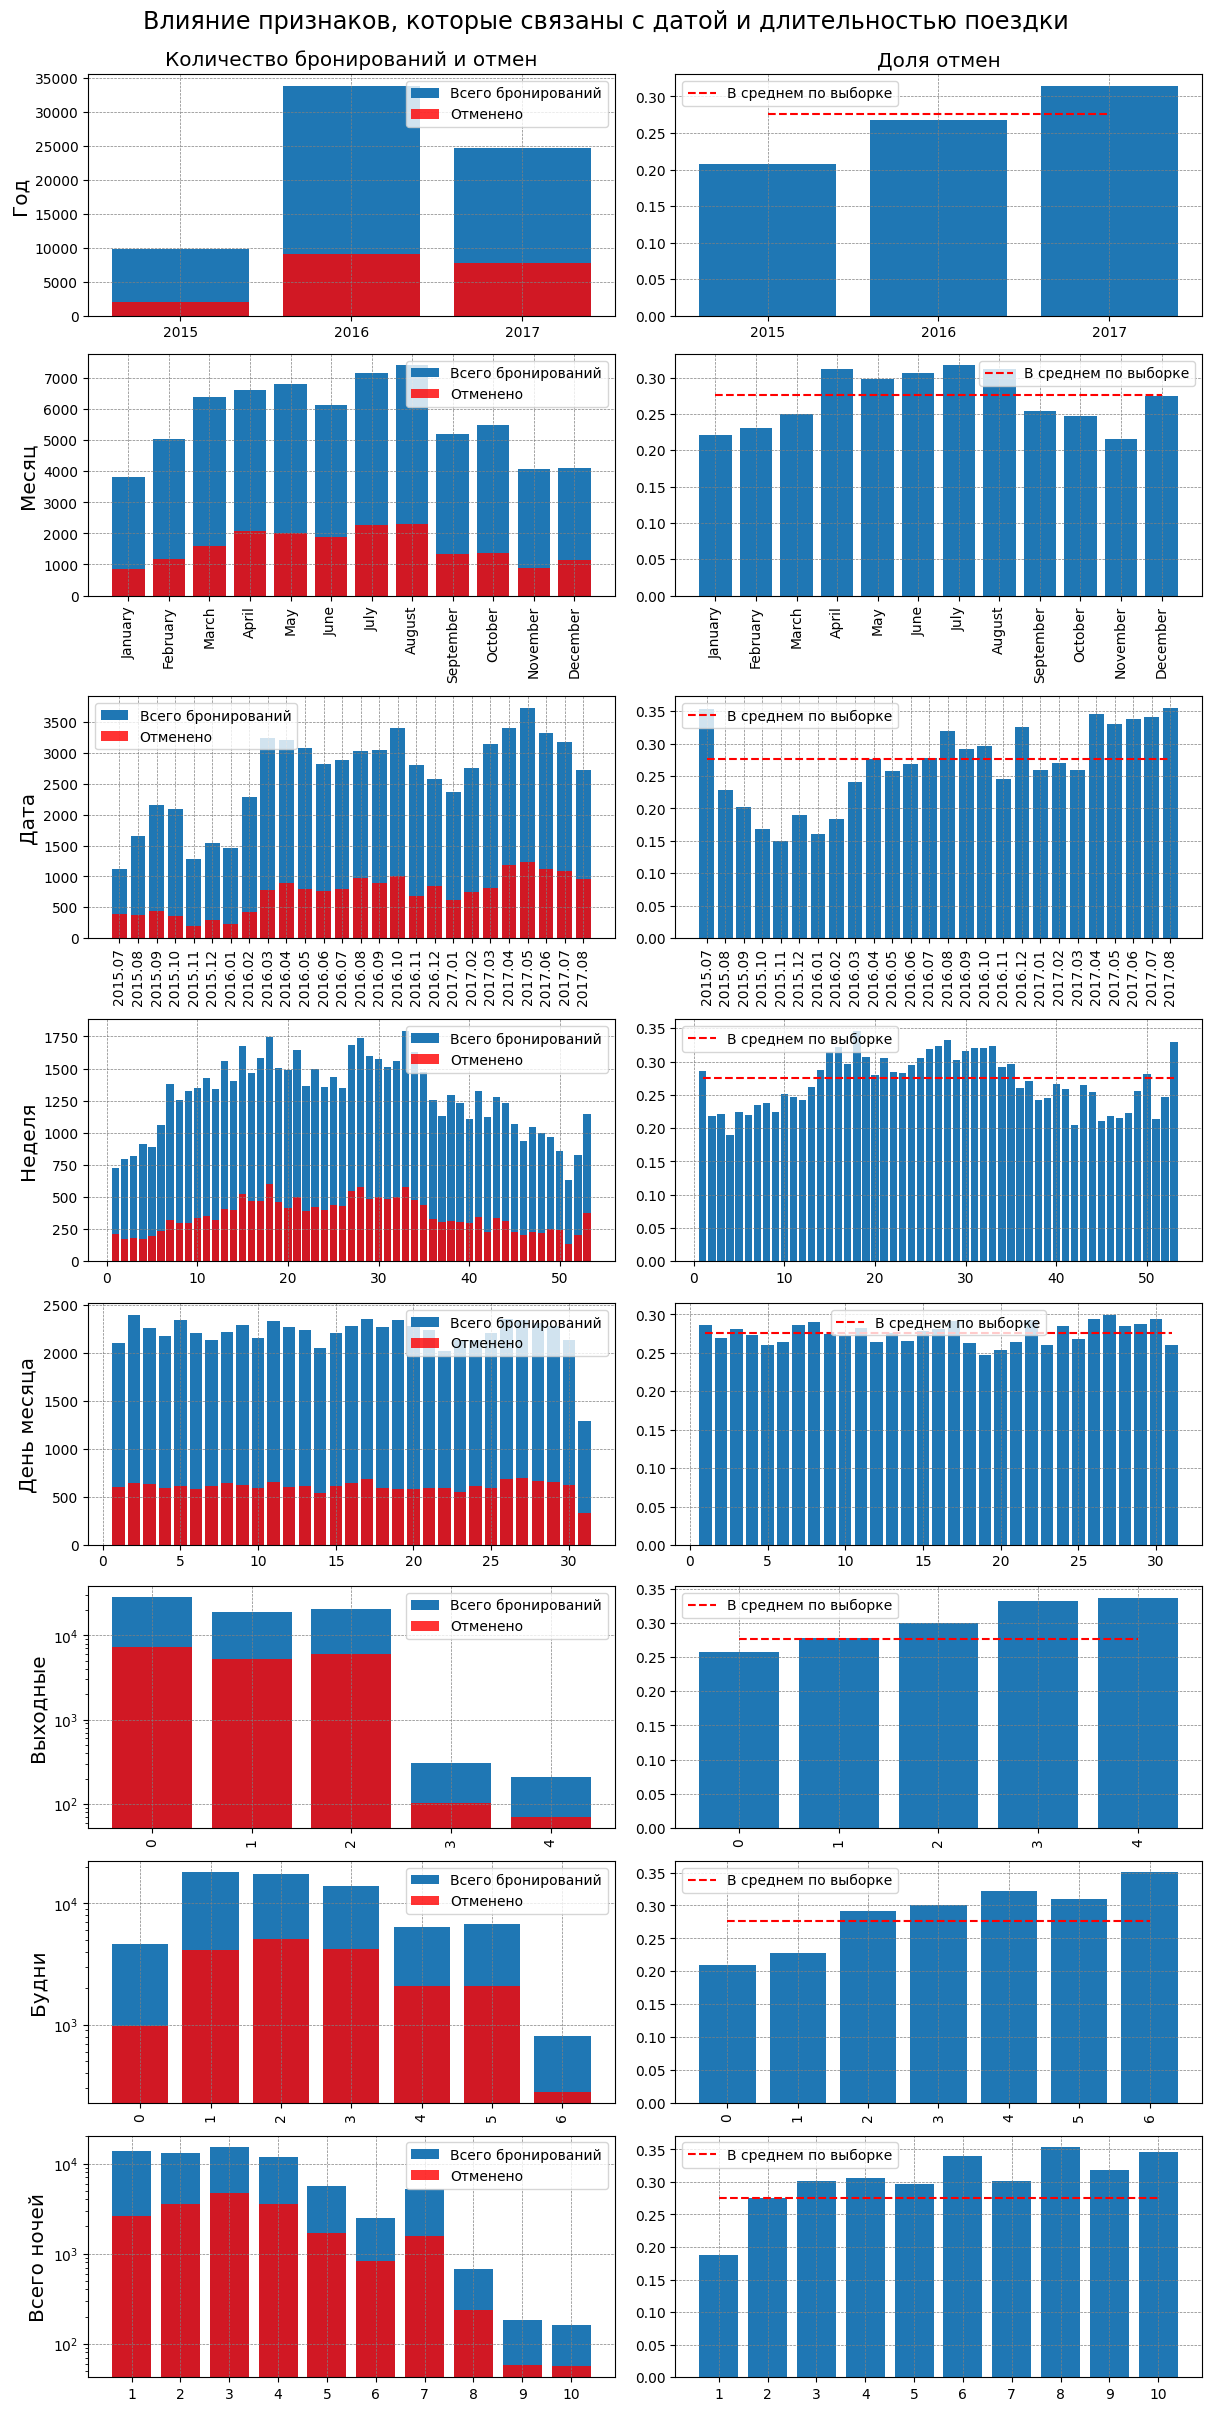

In [29]:
# Посмотрим, как зависят бронирования от рассматриваемых признаков.
# Слева построим зависимость количества бронирований и отмен от признака, а справа - доли отменённых бронирований.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(ncols=2, nrows=8,
                       figsize=(12, 24),
                       sharex=False,
                       gridspec_kw={'width_ratios': (.5, .5)},
                       constrained_layout=True)
fig.suptitle('Влияние признаков, которые связаны с датой и длительностью поездки',
             fontsize='xx-large')
ax[0, 0].set_title('Количество бронирований и отмен', fontsize='x-large')
ax[0, 1].set_title('Доля отмен', fontsize='x-large')
data = pd.concat([train, test])
data['date'] = data['date'].dt.strftime('%Y.%m')
data['month_num'] = data['arrival_date_month'].apply(month_number)
year_data = data.groupby(by='arrival_date_year')['is_canceled'].agg(['count', 'sum', 'mean'])
month_data = data.groupby(by='arrival_date_month').\
                  agg(count=('is_canceled','count'), sum=('is_canceled','sum'), \
                  mean=('is_canceled','mean'), month=('month_num','first')).\
                  sort_values(by='month').drop('month', axis=1)
week_data = data.groupby(by='arrival_date_week_number')['is_canceled'].agg(['count', 'sum', 'mean'])
day_data = data.groupby(by='arrival_date_day_of_month')['is_canceled'].agg(['count', 'sum', 'mean'])
weekend_data = data.groupby(by='stays_in_weekend_nights')['is_canceled'].agg(['count', 'sum', 'mean'])
weekday_data = data.groupby(by='stays_in_week_nights')['is_canceled'].agg(['count', 'sum', 'mean'])
nights_data = data.groupby(by='total_nights')['is_canceled'].agg(['count', 'sum', 'mean'])
date_data = data.groupby(by='date')['is_canceled'].agg(['count', 'sum', 'mean'])

for i in range(0,8):
    for j in range(0,2):
        ax[i, j].grid(color='gray', linewidth = 0.5, linestyle = '--')
        if i == 0:
            ax[i, j].set_xticks(year_data.index)
            ax[i, j].set_xticklabels(year_data.index, rotation=0)            
        if i == 1:
            ax[i, j].set_xticks(range(len(month_data.index)))
            ax[i, j].set_xticklabels(month_data.index, rotation=90)
        if i == 2:
            ax[i, j].set_xticks(range(len(date_data.index)))
            ax[i, j].set_xticklabels(date_data.index, rotation=90)
        if i == 5:
            ax[i, j].set_xticks(weekend_data.index)
            ax[i, j].set_xticklabels(weekend_data.index, rotation=90)
        if i == 6:
            ax[i, j].set_xticks(weekday_data.index)
            ax[i, j].set_xticklabels(weekday_data.index, rotation=90)
        if i == 7:
            ax[i, j].set_xticks(nights_data.index)
            ax[i, j].set_xticklabels(nights_data.index, rotation=0)
        
# Построим графики для года заезда
ax[0, 0].set_ylabel('Год', fontsize='x-large')
labels = year_data.index
ax[0, 0].bar(labels, year_data['count'], label='Всего бронирований')
ax[0, 0].bar(labels, year_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[0, 0].legend()
ax[0, 1].bar(labels, year_data['mean'])
ax[0, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[0, 1].legend()
# Построим графики для месяца заезда
ax[1, 0].set_ylabel('Месяц', fontsize='x-large')
labels = month_data.index
ax[1, 0].bar(labels, month_data['count'], label='Всего бронирований')
ax[1, 0].bar(labels, month_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[1, 0].legend()
ax[1, 1].bar(labels, month_data['mean'])
ax[1, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[1, 1].legend()
# Построим графики для даты заезда
ax[2, 0].set_ylabel('Дата', fontsize='x-large')
labels = date_data.index
ax[2, 0].bar(labels, date_data['count'], label='Всего бронирований')
ax[2, 0].bar(labels, date_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[2, 0].legend()
ax[2, 1].bar(labels, date_data['mean'])
ax[2, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[2, 1].legend()
# Построим графики для недели заезда
ax[3, 0].set_ylabel('Неделя', fontsize='x-large')
labels = week_data.index
ax[3, 0].bar(labels, week_data['count'], label='Всего бронирований')
ax[3, 0].bar(labels, week_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[3, 0].legend()
ax[3, 1].bar(labels, week_data['mean'])
ax[3, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[3, 1].legend()
# Построим графики для дня месяца
ax[4, 0].set_ylabel('День месяца', fontsize='x-large')
labels = day_data.index
ax[4, 0].bar(labels, day_data['count'], label='Всего бронирований')
ax[4, 0].bar(labels, day_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[4, 0].legend()
ax[4, 1].bar(labels, day_data['mean'])
ax[4, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[4, 1].legend()
# Построим графики для ночей в выходные дни
ax[5, 0].set_ylabel('Выходные', fontsize='x-large')
ax[5, 0].set_yscale('log')
labels = weekend_data.index
ax[5, 0].bar(labels, weekend_data['count'], label='Всего бронирований')
ax[5, 0].bar(labels, weekend_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[5, 0].legend()
ax[5, 1].bar(labels, weekend_data['mean'])
ax[5, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[5, 1].legend()
# Построим графики для ночей в будни
ax[6, 0].set_ylabel('Будни', fontsize='x-large')
ax[6, 0].set_yscale('log')
labels = weekday_data.index
ax[6, 0].bar(labels, weekday_data['count'], label='Всего бронирований')
ax[6, 0].bar(labels, weekday_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[6, 0].legend()
ax[6, 1].bar(labels, weekday_data['mean'])
ax[6, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[6, 1].legend()
# Построим графики для суммарного количества ночей
ax[7, 0].set_ylabel('Всего ночей', fontsize='x-large')
ax[7, 0].set_yscale('log')
labels = nights_data.index
ax[7, 0].bar(labels, nights_data['count'], label='Всего бронирований')
ax[7, 0].bar(labels, nights_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[7, 0].legend()
ax[7, 1].bar(labels, nights_data['mean'])
ax[7, 1].plot([labels[0], labels[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[7, 1].legend()
plt.show()

По данным можно сделать следующие выводы:
- год от года доля отмен постепенно увеличивается, но какую-то связь целевого признака с номером года устанавливать некорректно, уберём этот признак из выборки. Никакой информации с точки зрения прогнозирования целевого признака он не несёт;
- доля отмен максимальна в период с апреля по август. Минимальная доля отмен наблюдается в январе-марте, ноябре;
- у брониирований в последней неделе месяца доля отмен чаще превышает среднее значение по выборке, чем в другие дни месяца;
- у бронирований с захватом 2-4 выходных дней и 4-6 будних дней доля отмен выше среднего значения. Максимальная доля отмен наблюдается при бонировании 6,8,10 ночей. Минимальная доля отмен наблюдается при бронировании на 1 ночь. Поскольку число общих ночей складывается из числа ночей в будни и числа ночей в выходные, то уберём этот лишний признак, для обучения модели он лишний.

In [30]:
# Уберём признаки, созданные ранее для анализа данных, а также признак с годом заезда и с общим количеством ночей.
train = train.drop(['date', 'arrival_date_year', 'total_nights'], axis=1)
test = test.drop(['date', 'arrival_date_year', 'total_nights'], axis=1)

#### О заказчике

Исследуем признаки, связанные с заказчиком:
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `distribution_channel` — канал дистрибуции заказа;
- `booking_changes` — количество изменений параметров заказа;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз.

In [31]:
# Посмотрим, как представлены значения признаков в имеющихся данных
print('Гражданство постояльца')
display(feature_count(train, test, 'country'))

print('Тип заказчика')
display(feature_count(train, test, 'customer_type'))

print('Канал дистрибуции заказа')
display(feature_count(train, test, 'distribution_channel'))

print('Количество изменений параметров заказа')
display(feature_count(train, test, 'booking_changes'))

print('Количество отменённых заказов у клиента')
display(feature_count(train, test, 'previous_cancellations'))

print('Количество подтверждённых заказов у клиента')
display(feature_count(train, test, 'previous_bookings_not_canceled'))

print('Сколько дней заказ ожидал подтверждения')
display(feature_count(train, test, 'days_in_waiting_list'))

print('Количество дней между датой бронирования и датой прибытия')
display(feature_count(train, test, 'lead_time'))

print('Признак того, что гость бронирует номер второй раз')
display(feature_count(train, test, 'is_repeated_guest'))

Гражданство постояльца


,Значение country,Частота в train,Доля в train,Частота в test,Доля в test
0,PRT,14427.0,0.330243,5430.0,0.220463
1,FRA,4809.0,0.110081,2979.0,0.12095
2,GBR,4260.0,0.097514,3344.0,0.135769
3,ESP,3896.0,0.089182,1627.0,0.066058
4,DEU,2746.0,0.062858,1969.0,0.079943
...,...,...,...,...,...
169,NCL,,,1.0,0.000041
170,NPL,,,1.0,0.000041
171,SDN,,,1.0,0.000041
172,UMI,,,1.0,0.000041


Тип заказчика


,Значение customer_type,Частота в train,Доля в train,Частота в test,Доля в test
0,Transient,35278,0.807536,21904,0.889322
1,Transient-Party,6277,0.143684,2234,0.090702
2,Contract,1873,0.042874,334,0.013561
3,Group,258,0.005906,158,0.006415


Канал дистрибуции заказа


,Значение distribution_channel,Частота в train,Доля в train,Частота в test,Доля в test
0,TA/TO,35043,0.802156,20162,0.818595
1,Direct,5800,0.132766,3176,0.128948
2,Corporate,2753,0.063018,1213,0.049249
3,GDS,90,0.002060,79,0.003207


Количество изменений параметров заказа


,Значение booking_changes,Частота в train,Доля в train,Частота в test,Доля в test
0,0,36150.0,0.827496,20572.0,0.835242
1,1,5359.0,0.122671,2580.0,0.10475
2,2,1569.0,0.035915,1064.0,0.043199
3,3,371.0,0.008492,252.0,0.010231
4,4,138.0,0.003159,109.0,0.004425
5,5,40.0,0.000916,26.0,0.001056
6,6,18.0,0.000412,15.0,0.000609
7,7,17.0,0.000389,5.0,0.000203
8,8,7.0,0.00016,1.0,0.000041
9,9,5.0,0.000114,,


Количество отменённых заказов у клиента


,Значение previous_cancellations,Частота в train,Доля в train,Частота в test,Доля в test
0,0,42536,0.973676,24408.0,0.990987
1,1,994,0.022753,161.0,0.006537
2,2,52,0.001190,29.0,0.001177
3,3,47,0.001076,6.0,0.000244
4,11,27,0.000618,,
5,5,13,0.000298,1.0,0.000041
6,4,5,0.000114,10.0,0.000406
7,13,3,0.000069,,
8,6,2,0.000046,15.0,0.000609
9,24,2,0.000046,,


Количество подтверждённых заказов у клиента


,Значение previous_bookings_not_canceled,Частота в train,Доля в train,Частота в test,Доля в test
0,0,42203.0,0.966053,23602.0,0.958262
1,1,597.0,0.013666,406.0,0.016484
2,2,251.0,0.005746,160.0,0.006496
3,3,134.0,0.003067,87.0,0.003532
4,4,113.0,0.002587,59.0,0.002395
...,...,...,...,...,...
67,67,,,1.0,0.000041
68,66,,,1.0,0.000041
69,65,,,1.0,0.000041
70,64,,,1.0,0.000041


Сколько дней заказ ожидал подтверждения


,Значение days_in_waiting_list,Частота в train,Доля в train,Частота в test,Доля в test
0,0,43206.0,0.989012,24455.0,0.992895
1,63,42.0,0.000961,3.0,0.000122
2,15,19.0,0.000435,2.0,0.000081
3,87,18.0,0.000412,,
4,48,16.0,0.000366,,
...,...,...,...,...,...
115,54,,,1.0,0.000041
116,73,,,1.0,0.000041
117,105,,,1.0,0.000041
118,121,,,1.0,0.000041


Количество дней между датой бронирования и датой прибытия


,Значение lead_time,Частота в train,Доля в train,Частота в test,Доля в test
0,0,3105.0,0.071075,1290.0,0.052375
1,1,1766.0,0.040425,741.0,0.030085
2,2,1057.0,0.024195,453.0,0.018392
3,3,973.0,0.022273,370.0,0.015022
4,4,895.0,0.020487,348.0,0.014129
...,...,...,...,...,...
367,367,1.0,0.000023,1.0,0.000041
368,373,1.0,0.000023,2.0,0.000081
369,357,,,10.0,0.000406
370,368,,,6.0,0.000244


Признак того, что гость бронирует номер второй раз


,Значение is_repeated_guest,Частота в train,Доля в train,Частота в test,Доля в test
0,0,42243,0.966969,23631,0.95944
1,1,1443,0.033031,999,0.04056


По частоте значений признаков данные в обучающей и тестовой выборках распределны схожим образом.

Имеются значения, с которыми следует поработать:
- большое количество редких значений гражданства. Объединим в группу `others 0-300` все значения гражданства, которые встречаются не более 300 раз в выборке и `others 300-1000` - которые встречаются более 300, не не более 1000 раз;
- большое количество редких значений количества изменений параметров заказа. Данный признак представим категориями: `changes_0`, `change_1`, `changes_2`, `changes_3_and_more`;
- большое количество редких значений количества отменённых заказов. Данный признак представим категориями: `cancel_0`, `cancel_1`, `cancel_2_and_more`;
- большое количество редких значений количества подтверждённых заказов у клиента. Данный признак представим категориями: `orders_0`, `orders_1`, `orders_2`, `orders_3_and_more`;
- количество дней ожидания подтверждения заказа преобразуем в признак с категориями: `same_day` - заказ подтверждён в тот же день, `another_day` - заказ подтверждён на следующий день или позднее.

In [32]:
# Обработаем призак гражданства
others_0_300_country=[]
others_300_1000_country=[]
for country in train['country'].unique():
    if train[train['country']==country]['adults'].count() > 0 and\
       train[train['country']==country]['adults'].count() <= 300:
        others_0_300_country.append(country)
    if train[train['country']==country]['adults'].count() > 300 and\
       train[train['country']==country]['adults'].count() <= 1000:
        others_300_1000_country.append(country)    
# Для остальных значений признака (когда число записей менее 100), присвоим одно значение
train.loc[train['country'].isin(others_0_300_country), 'country'] = 'others 0-300'
train.loc[train['country'].isin(others_300_1000_country), 'country'] = 'others 300-1000'
test.loc[test['country'].isin(others_0_300_country), 'country'] = 'others 0-300'
test.loc[test['country'].isin(others_300_1000_country), 'country'] = 'others 300-1000'

# Редкие значения в тестовой выборке также поместим в категории, если до этого они ещё не попали в них
others_0_300_country=[]
others_300_1000_country=[]
for country in test['country'].unique():
    if test[test['country']==country]['adults'].count() > 0 and\
       test[test['country']==country]['adults'].count() <= 300:
        others_0_300_country.append(country)
    if test[test['country']==country]['adults'].count() > 300 and\
       test[test['country']==country]['adults'].count() <= 1000:
        others_300_1000_country.append(country)    
test.loc[test['country'].isin(others_0_300_country), 'country'] = 'others 0-300'
test.loc[test['country'].isin(others_300_1000_country), 'country'] = 'others 300-1000'

# Проверим результат
display(feature_count(train, test, 'country'))

,Значение country,Частота в train,Доля в train,Частота в test,Доля в test
0,PRT,14427,0.330243,5430.0,0.220463
1,FRA,4809,0.110081,2979.0,0.12095
2,others 300-1000,4716,0.107952,6816.0,0.276736
3,GBR,4260,0.097514,3344.0,0.135769
4,ESP,3896,0.089182,1627.0,0.066058
5,others 0-300,3742,0.085657,2465.0,0.100081
6,DEU,2746,0.062858,1969.0,0.079943
7,ITA,1766,0.040425,,
8,IRL,1233,0.028224,,
9,BEL,1065,0.024379,,


В обучающей выборке не осталось редких значений. В тестовой выборке оставим так, как есть, так как в реальных данных могут появляться новые значения рассматриваемого признака.

In [33]:
# Обработаем количество изменений параметров заказа.
# Данный признак представим категориями: changes_0, change_1, changes_2, changes_3_and_more
for value in range(0,3):
    train.loc[train['booking_changes']==value, 'booking_changes'] = 'changes_'+str(value)
    test.loc[test['booking_changes']==value, 'booking_changes'] = 'changes_'+str(value)
train.loc[~((train['booking_changes']=='changes_0')|\
          (train['booking_changes']=='changes_1')|\
          (train['booking_changes']=='changes_2')), 'booking_changes'] = 'changes_3_and_more'
test.loc[~((test['booking_changes']=='changes_0')|\
          (test['booking_changes']=='changes_1')|\
          (test['booking_changes']=='changes_2')), 'booking_changes'] = 'changes_3_and_more'
# Проверим результат
display(feature_count(train, test, 'booking_changes'))

,Значение booking_changes,Частота в train,Доля в train,Частота в test,Доля в test
0,changes_0,36150,0.827496,20572,0.835242
1,changes_1,5359,0.122671,2580,0.104750
2,changes_2,1569,0.035915,1064,0.043199
3,changes_3_and_more,608,0.013918,414,0.016809


In [34]:
# Обработаем количество отменённых заказов.
# Данный признак представим категориями: cancel_0, cancel_1, cancel_2_and_more
for value in range(0,2):
    train.loc[train['previous_cancellations']==value, 'previous_cancellations'] = 'cancel_'+str(value)
    test.loc[test['previous_cancellations']==value, 'previous_cancellations'] = 'cancel_'+str(value)
train.loc[~((train['previous_cancellations']=='cancel_0')|\
          (train['previous_cancellations']=='cancel_1')), 'previous_cancellations'] = 'cancel_2_and_more'
test.loc[~((test['previous_cancellations']=='cancel_0')|\
          (test['previous_cancellations']=='cancel_1')), 'previous_cancellations'] = 'cancel_2_and_more'
# Проверим результат
display(feature_count(train, test, 'previous_cancellations'))

,Значение previous_cancellations,Частота в train,Доля в train,Частота в test,Доля в test
0,cancel_0,42536,0.973676,24408,0.990987
1,cancel_1,994,0.022753,161,0.006537
2,cancel_2_and_more,156,0.003571,61,0.002477


In [35]:
# Обработаем количество подтверждённых заказов у клиента. Данный признак представим категориями:
# orders_0, orders_1, orders_2, orders_3_and_more.
for value in range(0,3):
    train.loc[train['previous_bookings_not_canceled']==value, 'previous_bookings_not_canceled'] = 'orders_'+str(value)
    test.loc[test['previous_bookings_not_canceled']==value, 'previous_bookings_not_canceled'] = 'orders_'+str(value)
train.loc[~((train['previous_bookings_not_canceled']=='orders_0')|\
          (train['previous_bookings_not_canceled']=='orders_1')|\
          (train['previous_bookings_not_canceled']=='orders_2')), 'previous_bookings_not_canceled'] = 'orders_3_and_more'
test.loc[~((test['previous_bookings_not_canceled']=='orders_0')|\
          (test['previous_bookings_not_canceled']=='orders_1')|\
          (test['previous_bookings_not_canceled']=='orders_2')), 'previous_bookings_not_canceled'] = 'orders_3_and_more'
# Проверим результат
display(feature_count(train, test, 'previous_bookings_not_canceled'))

,Значение previous_bookings_not_canceled,Частота в train,Доля в train,Частота в test,Доля в test
0,orders_0,42203,0.966053,23602,0.958262
1,orders_3_and_more,635,0.014536,462,0.018758
2,orders_1,597,0.013666,406,0.016484
3,orders_2,251,0.005746,160,0.006496


In [36]:
# Обработаем признак числа дней до подтверждения заказа.
# Данный признак представим категориями: same_day, another_day
train.loc[train['days_in_waiting_list']==0, 'days_in_waiting_list'] = 'same_day'
test.loc[test['days_in_waiting_list']==0, 'days_in_waiting_list'] = 'same_day'
train.loc[train['days_in_waiting_list']!='same_day', 'days_in_waiting_list'] = 'another_day'
test.loc[test['days_in_waiting_list']!='same_day', 'days_in_waiting_list'] = 'another_day'
# Проверим результат
display(feature_count(train, test, 'days_in_waiting_list'))

,Значение days_in_waiting_list,Частота в train,Доля в train,Частота в test,Доля в test
0,same_day,43206,0.989012,24455,0.992895
1,another_day,480,0.010988,175,0.007105


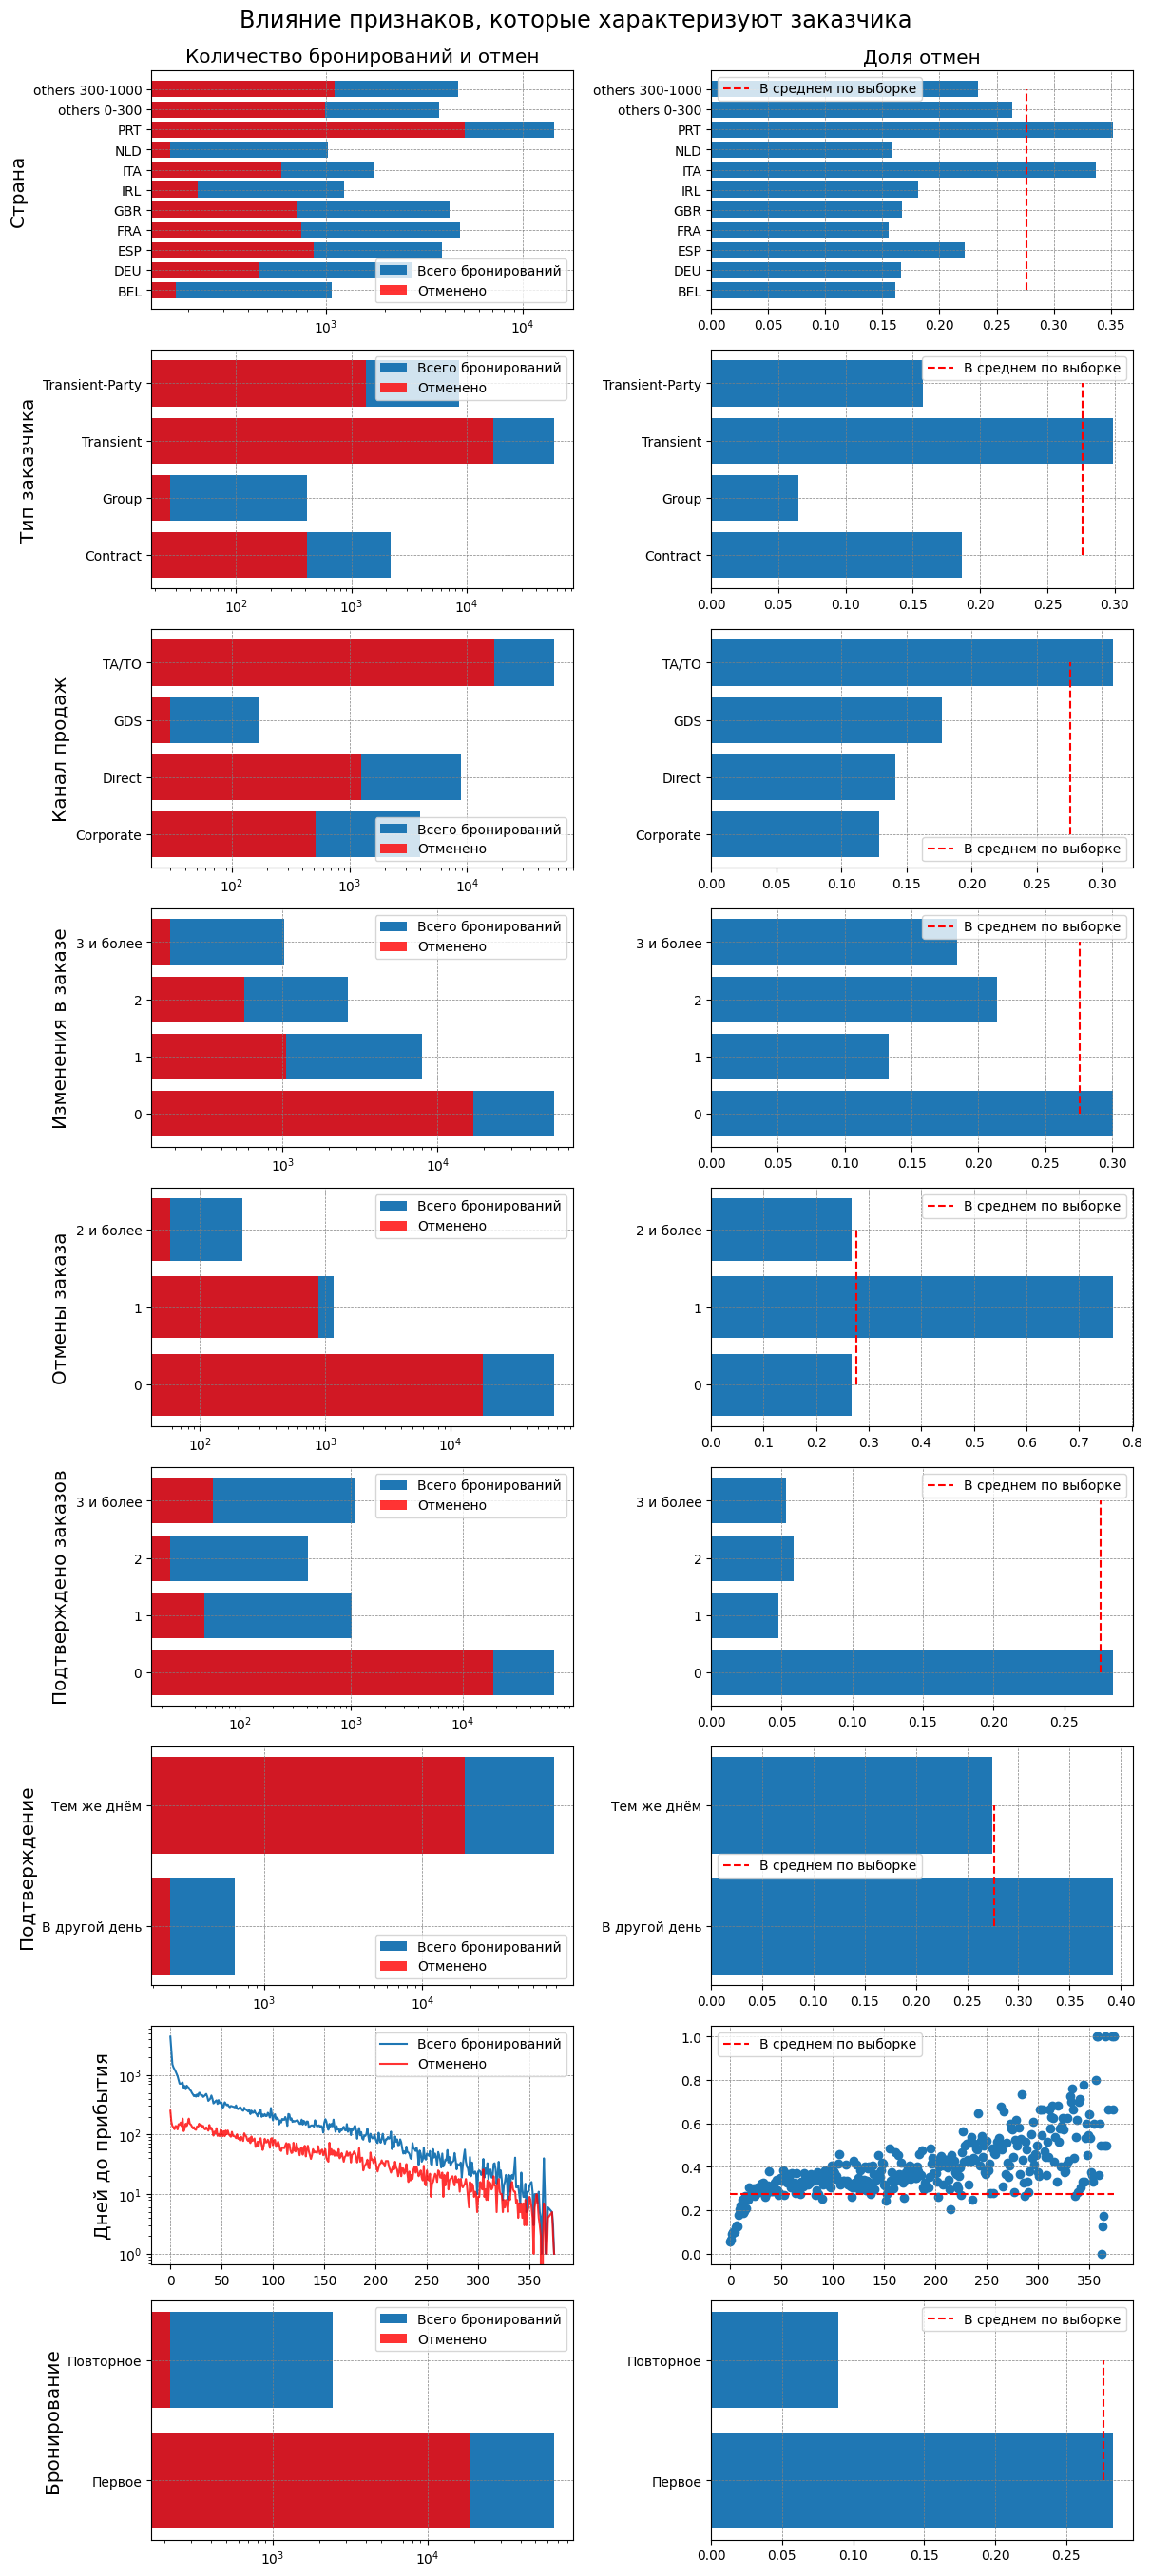

In [37]:
# Посмотрим, как зависят бронирования от рассматриваемых признаков.
# Слева построим зависимость количества бронирований и отмен от признака, а справа - доли отменённых бронирований.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(ncols=2, nrows=9,
                       figsize=(12, 27),
                       sharex=False,
                       gridspec_kw={'width_ratios': (.5, .5)},
                       constrained_layout=True)
fig.suptitle('Влияние признаков, которые характеризуют заказчика',
             fontsize='xx-large')
ax[0, 0].set_title('Количество бронирований и отмен', fontsize='x-large')
ax[0, 1].set_title('Доля отмен', fontsize='x-large')
data = pd.concat([train, test])
country_data = train.groupby(by='country')['is_canceled'].agg(['count', 'sum', 'mean'])
type_data = data.groupby(by='customer_type')['is_canceled'].agg(['count', 'sum', 'mean'])
channel_data = data.groupby(by='distribution_channel')['is_canceled'].agg(['count', 'sum', 'mean'])
changes_data = data.groupby(by='booking_changes')['is_canceled'].agg(['count', 'sum', 'mean'])
cancel_data = data.groupby(by='previous_cancellations')['is_canceled'].agg(['count', 'sum', 'mean'])
order_data = data.groupby(by='previous_bookings_not_canceled')['is_canceled'].agg(['count', 'sum', 'mean'])
wait_data = data.groupby(by='days_in_waiting_list')['is_canceled'].agg(['count', 'sum', 'mean'])
lead_data = data.groupby(by='lead_time')['is_canceled'].agg(['count', 'sum', 'mean'])
repeat_data = data.groupby(by='is_repeated_guest')['is_canceled'].agg(['count', 'sum', 'mean'])
for i in range(0,9):
    for j in range(0,2):
        ax[i, j].grid(color='gray', linewidth = 0.5, linestyle = '--')
        
# Построим графики для гражданства заказчика
ax[0, 0].set_yticks(range(len(country_data.index)))
ax[0, 0].set_yticklabels(country_data.index, rotation=0)
ax[0, 0].set_ylabel('Страна', fontsize='x-large') 
ax[0, 0].set_xscale('log')
labels = country_data.index
ax[0, 0].barh(labels, country_data['count'], label='Всего бронирований')
ax[0, 0].barh(labels, country_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[0, 0].legend()
ax[0, 1].barh(labels, country_data['mean'])
ax[0, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[0, 1].legend()
# Построим графики для типа заказчика
ax[1, 0].set_yticks(range(len(type_data.index)))
ax[1, 0].set_yticklabels(type_data.index, rotation=0)
ax[1, 0].set_ylabel('Тип заказчика', fontsize='x-large')
ax[1, 0].set_xscale('log')
labels = type_data.index
ax[1, 0].barh(labels, type_data['count'], label='Всего бронирований')
ax[1, 0].barh(labels, type_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[1, 0].legend()
ax[1, 1].barh(labels, type_data['mean'])
ax[1, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[1, 1].legend()
# Построим графики для канала дистрибуции
ax[2, j].set_yticks(range(len(channel_data.index)))
ax[2, j].set_yticklabels(channel_data.index, rotation=0)
ax[2, 0].set_ylabel('Канал продаж', fontsize='x-large')
ax[2, 0].set_xscale('log')
labels = channel_data.index
ax[2, 0].barh(labels, channel_data['count'], label='Всего бронирований')
ax[2, 0].barh(labels, channel_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[2, 0].legend()
ax[2, 1].barh(labels, channel_data['mean'])
ax[2, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[2, 1].legend()
# Построим графики для количества изменений заказа
labels = ['0', '1', '2', '3 и более']
ax[3, 0].set_yticks(range(len(changes_data.index)))
ax[3, 0].set_yticklabels(labels, rotation=0)
ax[3, 0].set_ylabel('Изменения в заказе', fontsize='x-large')
ax[3, 0].set_xscale('log')
ax[3, 0].barh(labels, changes_data['count'], label='Всего бронирований')
ax[3, 0].barh(labels, changes_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[3, 0].legend()
ax[3, 1].barh(labels, changes_data['mean'])
ax[3, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[3, 1].legend()
# Построим графики для количества отменённых заказов
labels = ['0', '1', '2 и более']
ax[4, 0].set_yticks(range(len(cancel_data.index)))
ax[4, 0].set_yticklabels(labels, rotation=0)
ax[4, 0].set_ylabel('Отмены заказа', fontsize='x-large')
ax[4, 0].set_xscale('log')
ax[4, 0].barh(labels, cancel_data['count'], label='Всего бронирований')
ax[4, 0].barh(labels, cancel_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[4, 0].legend()
ax[4, 1].barh(labels, cancel_data['mean'])
ax[4, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[4, 1].legend()
# Построим графики для количества пошлых заказов
labels = ['0', '1', '2', '3 и более']
ax[5, 0].set_yticks(range(len(order_data.index)))
ax[5, 0].set_yticklabels(labels, rotation=0)
ax[5, 0].set_ylabel('Подтверждено заказов', fontsize='x-large')
ax[5, 0].set_xscale('log')
ax[5, 0].barh(labels, order_data['count'], label='Всего бронирований')
ax[5, 0].barh(labels, order_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[5, 0].legend()
ax[5, 1].barh(labels, order_data['mean'])
ax[5, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[5, 1].legend()
# Построим графики для дней ожидания подтверждения заказа
labels = ['В другой день', 'Тем же днём']
ax[6, 0].set_yticks(range(len(wait_data.index)))
ax[6, 0].set_yticklabels(labels, rotation=0)
ax[6, 0].set_ylabel('Подтверждение', fontsize='x-large')
ax[6, 0].set_xscale('log')
ax[6, 0].barh(labels, wait_data['count'], label='Всего бронирований')
ax[6, 0].barh(labels, wait_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[6, 0].legend()
ax[6, 1].barh(labels, wait_data['mean'])
ax[6, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[6, 1].legend()
# Построим графики для дней до прибытия
ax[7, 0].set_ylabel('Дней до прибытия', fontsize='x-large')
ax[7, 0].set_yscale('log')
ax[7, 0].plot(lead_data['count'], label='Всего бронирований')
ax[7, 0].plot(lead_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[7, 0].legend()
ax[7, 1].scatter(lead_data.index, lead_data['mean'])
ax[7, 1].plot([lead_data.index[0], lead_data.index[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[7, 1].legend()
# Построим графики для признака повторного бронирования
ax[8, 0].set_ylabel('Бронирование', fontsize='x-large')
ax[8, 0].set_xscale('log')
labels = ['Первое', 'Повторное']
ax[8, 0].barh(labels, repeat_data['count'], label='Всего бронирований')
ax[8, 0].barh(labels, repeat_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[8, 0].legend()
ax[8, 1].barh(labels, repeat_data['mean'])
ax[8, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[8, 1].legend()
plt.show()

По данным можно сделать следующие выводы:
- максимальная доля отмен наблюдается у заказчиков с гражданством Португалии, Италии (существенно выше среднего), минимальная доля отмен - у заказчиков с гражданством Нидерландов, Франции, Бельгии, Германии;
- у заказов, не связанных с договором или групповым заездом, доля отмен выше среднего. При групповом заезде доля отмен существенно ниже среднего;
- максимальная доля отмен наблюдается в канале продаж TA/TO, по остальным каналам доля отмен существенно ниже среднего;
- если параметры заказа не менялись, то доля отмен выше среднего и существенно выше, чем у заказчиков, которые редактировали параметры заказа. Укрупним категории признака, сократив их количество до двух - либо не менял параметры заказа, либо менял;
- доля отмен у заказчиков, отменявших ранее один заказ, существенно выше среднего значения. Укрупним категории признака, сократив их количество до двух - либо отменял ранее заказ, либо не отменял;
- если подтверждённых заказов у заказчика не было, то доля отмен приблизительна равна среднему значению и существенно выше, чем у заказчиков, которые ранее подтверждали хотя бы один заказ. Укрупним категории признака, сократив их количество до двух - либо подтверждал ранее заказ, либо не подтверждал;
- если заказ не подтверждается в тот же день (дней ожидания подтверждения 1 и более), то доля отмен существенно выше среднего;
- при количестве дней между датой бронирования и датой прибытия 50 и более, доля отмен в основном выше среднего, если же до прибытия менее 50 дней, то доля отмен - ниже среднего;
- доля отмен при повторном бронировании существенно ниже среднего, при первом бронировании доля отмен приблизительно равна среднему значению.

In [38]:
# Обработаем количество изменений параметров заказа.
# Данный признак представим категориями: not_changed, changed
train.loc[train['booking_changes']=='changes_0', 'booking_changes'] = 'not_changed'
test.loc[test['booking_changes']=='changes_0', 'booking_changes'] = 'not_changed'
train.loc[train['booking_changes']!='not_changed', 'booking_changes'] = 'changed'
test.loc[test['booking_changes']!='not_changed', 'booking_changes'] = 'changed'
# Проверим результат
display(feature_count(train, test, 'booking_changes'))

,Значение booking_changes,Частота в train,Доля в train,Частота в test,Доля в test
0,not_changed,36150,0.827496,20572,0.835242
1,changed,7536,0.172504,4058,0.164758


In [39]:
# Обработаем количество отменённых заказов.
# Данный признак представим категориями: wasnt_cancelations, was_cancelations
train.loc[train['previous_cancellations']=='cancel_0', 'previous_cancellations'] = 'wasnt_cancelations'
test.loc[test['previous_cancellations']=='cancel_0', 'previous_cancellations'] = 'wasnt_cancelations'
train.loc[train['previous_cancellations']!='wasnt_cancelations', 'previous_cancellations'] = 'was_cancelations'
test.loc[test['previous_cancellations']!='wasnt_cancelations', 'previous_cancellations'] = 'was_cancelations'
# Проверим результат
display(feature_count(train, test, 'previous_cancellations'))

,Значение previous_cancellations,Частота в train,Доля в train,Частота в test,Доля в test
0,wasnt_cancelations,42536,0.973676,24408,0.990987
1,was_cancelations,1150,0.026324,222,0.009013


In [40]:
# Обработаем количество подтверждённых заказов у клиента. Данный признак представим категориями:
# first_order, not_first_order
train.loc[train['previous_bookings_not_canceled']=='orders_0', 'previous_bookings_not_canceled'] = 'first_order'
test.loc[test['previous_bookings_not_canceled']=='orders_0', 'previous_bookings_not_canceled'] = 'first_order'
train.loc[train['previous_bookings_not_canceled']!='first_order', 'previous_bookings_not_canceled'] = 'not_first_order'
test.loc[test['previous_bookings_not_canceled']!='first_order', 'previous_bookings_not_canceled'] = 'not_first_order'
# Проверим результат
display(feature_count(train, test, 'previous_bookings_not_canceled'))

,Значение previous_bookings_not_canceled,Частота в train,Доля в train,Частота в test,Доля в test
0,first_order,42203,0.966053,23602,0.958262
1,not_first_order,1483,0.033947,1028,0.041738


#### О заказе

Исследуем признаки, связанные с заказом:
- `meal` — опции заказа:
    * SC — нет дополнительных опций;
    * BB — включён завтрак;
    * HB — включён завтрак и обед;
    * FB — включён завтрак, обед и ужин.
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `total_of_special_requests` — количество специальных отметок.

In [41]:
# Посмотрим, как представлены значения признаков в имеющихся данных
print('Опции заказа')
display(feature_count(train, test, 'meal'))

print('Необходимость места для автомобиля')
display(feature_count(train, test, 'required_car_parking_spaces'))

print('Тип забронированной комнаты')
display(feature_count(train, test, 'reserved_room_type'))

print('Количество специальных отметок')
display(feature_count(train, test, 'total_of_special_requests'))

Опции заказа


,Значение meal,Частота в train,Доля в train,Частота в test,Доля в test
0,BB,35401,0.810351,18256,0.741210
1,SC,4656,0.106579,4384,0.177994
2,HB,3341,0.076478,1858,0.075436
3,SC,153,0.003502,102,0.004141
4,FB,135,0.003090,30,0.001218


Необходимость места для автомобиля


,Значение required_car_parking_spaces,Частота в train,Доля в train,Частота в test,Доля в test
0,0,40089.0,0.917662,23183,0.941251
1,1,3585.0,0.082063,1438,0.058384
2,2,11.0,0.000252,6,0.000244
3,3,1.0,0.000023,1,0.000041
4,8,,,2,0.000081


Тип забронированной комнаты


,Значение reserved_room_type,Частота в train,Доля в train,Частота в test,Доля в test
0,A,30431,0.696585,16632,0.675274
1,D,8420,0.192739,5431,0.220503
2,E,2251,0.051527,1489,0.060455
3,F,1176,0.026919,488,0.019813
4,B,601,0.013757,124,0.005035
5,G,580,0.013277,272,0.011043
6,C,227,0.005196,194,0.007877


Количество специальных отметок


,Значение total_of_special_requests,Частота в train,Доля в train,Частота в test,Доля в test
0,0,22369,0.512040,11473,0.465814
1,1,14526,0.332509,8652,0.351279
2,2,5750,0.131621,3540,0.143727
3,3,933,0.021357,835,0.033902
4,4,98,0.002243,113,0.004588
5,5,10,0.000229,17,0.000690


По частоте значений признаков данные в обучающей и тестовой выборках распределны схожим образом.

Имеются значения, с которыми следует поработать:
- в значениях признака `meal` имеются неявные дубликаты, уберём их;
- признак необходимого количества мест под автомобили содержит очень редкие значения. Данный признак представим категориями: `need_parking`, `dont_need_parking`,
- в значениях признака `reserved_room_type` уберём лишние пробелы в значениях.

In [42]:
# Обработаем опции заказа, убрав лишние пробелы в значениях.
train['meal'] = train['meal'].str.strip()
test['meal'] = test['meal'].str.strip()
# Проверим результат
display(feature_count(train, test, 'meal'))

,Значение meal,Частота в train,Доля в train,Частота в test,Доля в test
0,BB,35401,0.810351,18256,0.741210
1,SC,4809,0.110081,4486,0.182136
2,HB,3341,0.076478,1858,0.075436
3,FB,135,0.003090,30,0.001218


In [43]:
# Обработаем количество необходимых мест для парковки. Данный признак представим категориями:
# need_parking, dont_need_parking
train.loc[train['required_car_parking_spaces']==0, 'required_car_parking_spaces'] = 'dont_need_parking'
test.loc[test['required_car_parking_spaces']==0, 'required_car_parking_spaces'] = 'dont_need_parking'
train.loc[train['required_car_parking_spaces']!='dont_need_parking', 'required_car_parking_spaces'] = 'need_parking'
test.loc[test['required_car_parking_spaces']!='dont_need_parking', 'required_car_parking_spaces'] = 'need_parking'
# Проверим результат
display(feature_count(train, test, 'required_car_parking_spaces'))

,Значение required_car_parking_spaces,Частота в train,Доля в train,Частота в test,Доля в test
0,dont_need_parking,40089,0.917662,23183,0.941251
1,need_parking,3597,0.082338,1447,0.058749


In [44]:
# Обработаем категории комнат, убрав лишние пробелы в значениях.
train['reserved_room_type'] = train['reserved_room_type'].str.strip()
test['reserved_room_type'] = test['reserved_room_type'].str.strip()
# Проверим результат
display(feature_count(train, test, 'reserved_room_type'))

,Значение reserved_room_type,Частота в train,Доля в train,Частота в test,Доля в test
0,A,30431,0.696585,16632,0.675274
1,D,8420,0.192739,5431,0.220503
2,E,2251,0.051527,1489,0.060455
3,F,1176,0.026919,488,0.019813
4,B,601,0.013757,124,0.005035
5,G,580,0.013277,272,0.011043
6,C,227,0.005196,194,0.007877


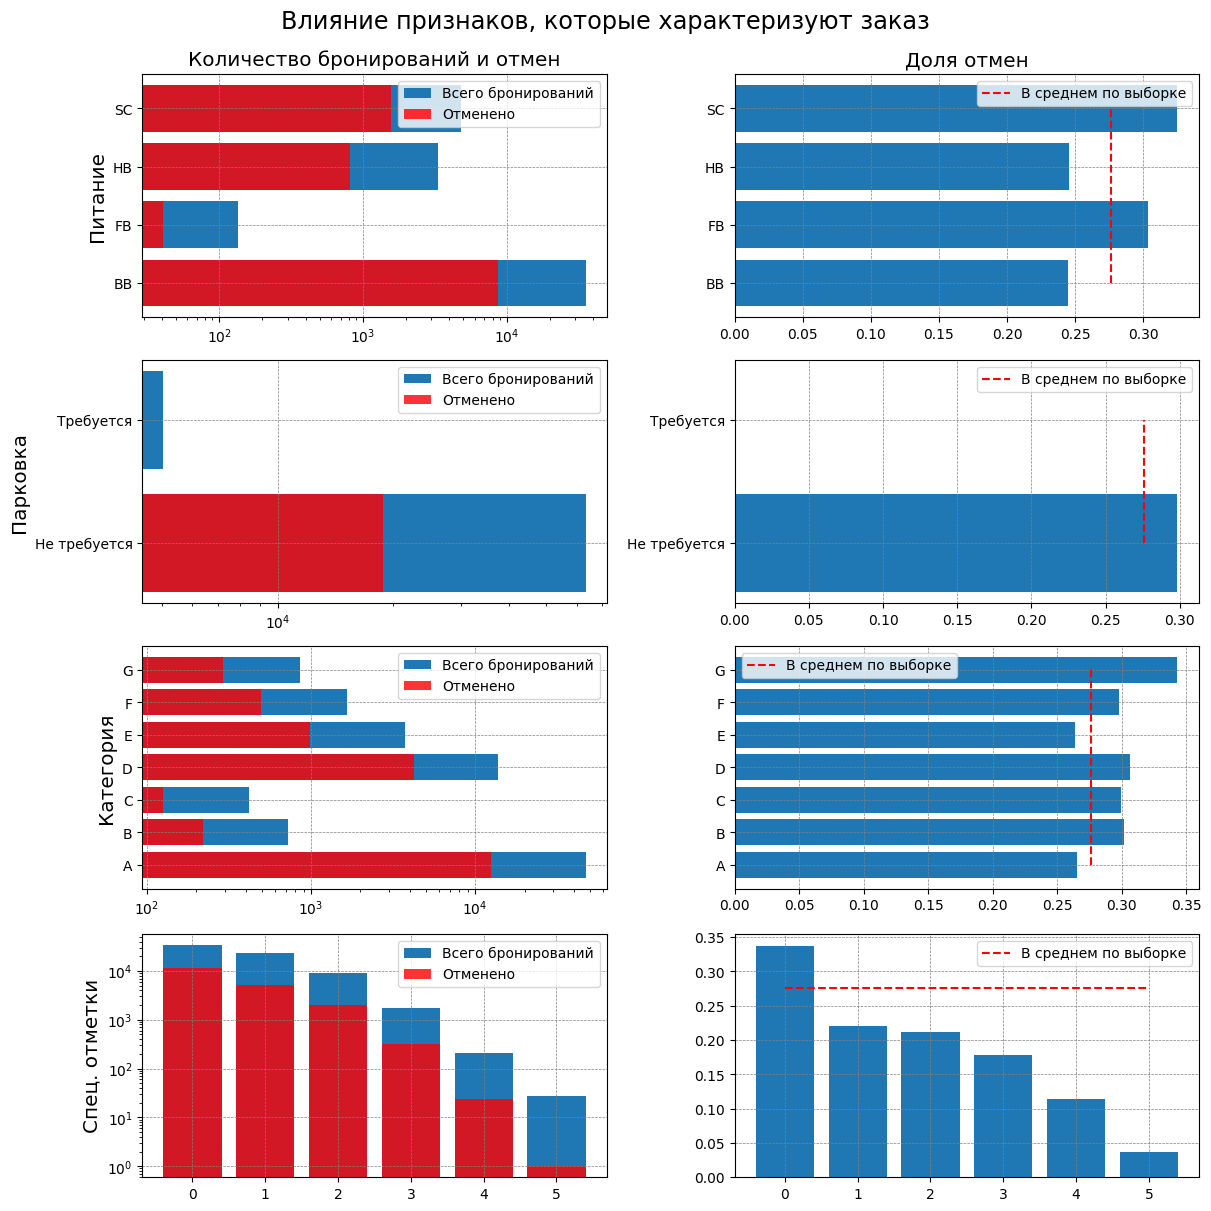

In [45]:
# Посмотрим, как зависят бронирования от рассматриваемых признаков.
# Слева построим зависимость количества бронирований и отмен от признака, а справа - доли отменённых бронирований.
# Настроим внешний вид области построения, обозначим оси
fig, ax = plt.subplots(ncols=2, nrows=4,
                       figsize=(12, 12),
                       sharex=False,
                       gridspec_kw={'width_ratios': (.5, .5)},
                       constrained_layout=True)
fig.suptitle('Влияние признаков, которые характеризуют заказ',
             fontsize='xx-large')
ax[0, 0].set_title('Количество бронирований и отмен', fontsize='x-large')
ax[0, 1].set_title('Доля отмен', fontsize='x-large')
data = pd.concat([train, test])
meal_data = train.groupby(by='meal')['is_canceled'].agg(['count', 'sum', 'mean'])
parking_data = data.groupby(by='required_car_parking_spaces')['is_canceled'].agg(['count', 'sum', 'mean'])
room_data = data.groupby(by='reserved_room_type')['is_canceled'].agg(['count', 'sum', 'mean'])
requests_data = data.groupby(by='total_of_special_requests')['is_canceled'].agg(['count', 'sum', 'mean'])
for i in range(0,4):
    for j in range(0,2):
        ax[i, j].grid(color='gray', linewidth = 0.5, linestyle = '--')
        
# Построим графики для опций заказа
ax[0, 0].set_yticks(range(len(meal_data.index)))
ax[0, 0].set_yticklabels(meal_data.index, rotation=0)
ax[0, 0].set_ylabel('Питание', fontsize='x-large') 
ax[0, 0].set_xscale('log')
labels = meal_data.index
ax[0, 0].barh(labels, meal_data['count'], label='Всего бронирований')
ax[0, 0].barh(labels, meal_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[0, 0].legend()
ax[0, 1].barh(labels, meal_data['mean'])
ax[0, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[0, 1].legend()
# Построим графики для признака необходимости парковки
ax[1, 0].set_yticks(range(len(parking_data.index)))
ax[1, 0].set_yticklabels(['Не требуется', 'Требуется'], rotation=0)
ax[1, 0].set_ylabel('Парковка', fontsize='x-large')
ax[1, 0].set_xscale('log')
labels = ['Не требуется', 'Требуется']
ax[1, 0].barh(labels, parking_data['count'], label='Всего бронирований')
ax[1, 0].barh(labels, parking_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[1, 0].legend()
ax[1, 1].barh(labels, parking_data['mean'])
ax[1, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[1, 1].legend()
# Построим графики для категории комнаты
ax[2, j].set_yticks(range(len(room_data.index)))
ax[2, j].set_yticklabels(room_data.index, rotation=0)
ax[2, 0].set_ylabel('Категория', fontsize='x-large')
ax[2, 0].set_xscale('log')
labels = room_data.index
ax[2, 0].barh(labels, room_data['count'], label='Всего бронирований')
ax[2, 0].barh(labels, room_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[2, 0].legend()
ax[2, 1].barh(labels, room_data['mean'])
ax[2, 1].plot([average]*2, [labels[0], labels[-1]], color='red', label='В среднем по выборке', linestyle = '--')
ax[2, 1].legend()
# Построим графики для количества специальных отметок
ax[3, 0].set_ylabel('Спец. отметки', fontsize='x-large')
ax[3, 0].set_yscale('log')
ax[3, 0].bar(requests_data.index, requests_data['count'], label='Всего бронирований')
ax[3, 0].bar(requests_data.index, requests_data['sum'], color='red', label='Отменено', alpha=0.8)
ax[3, 0].legend()
ax[3, 1].bar(requests_data.index, requests_data['mean'])
ax[3, 1].plot([requests_data.index[0], requests_data.index[-1]], [average]*2, color='red', label='В среднем по выборке', linestyle = '--')
ax[3, 1].legend()

plt.show()

По данным можно сделать следующие выводы:
- максимальная доля отмен наблюдается по заказам с опцией SC или FB (существенно выше среднего), по остальным заказам доля отмен ниже среднего значения;
- по заказам, в которых имеется требование о парковочном месте, отмен не было зафиксировано, по остальным заказам доля отмен незначительно выше среднего;
- максимальная доля отмен наблюдается по категории G, минимальная доля отмен - по категориям A, E;
- если в заказе отсутствуют специальные отметки, то доля отмен существенно выше среднего значения по выборке. Если имеются специальные отметки, то чем их больше, тем доля отмен ниже.

### Подготовка данных для моделей

#### Разделение данных

In [46]:
# Cбросим индексацию
# Сброс индексов необходим для последующей кросс-валидации (корректного выбора фолдов)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
# Посмотрим результат всех предыдущих действий
display(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43686 entries, 0 to 43685
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     43686 non-null  int64 
 1   lead_time                       43686 non-null  int64 
 2   arrival_date_month              43686 non-null  object
 3   arrival_date_week_number        43686 non-null  int64 
 4   arrival_date_day_of_month       43686 non-null  int64 
 5   stays_in_weekend_nights         43686 non-null  int64 
 6   stays_in_week_nights            43686 non-null  int64 
 7   adults                          43686 non-null  int64 
 8   children                        43686 non-null  object
 9   meal                            43686 non-null  object
 10  country                         43686 non-null  object
 11  distribution_channel            43686 non-null  object
 12  is_repeated_guest               43686 non-null

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24630 entries, 0 to 24629
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     24630 non-null  int64 
 1   lead_time                       24630 non-null  int64 
 2   arrival_date_month              24630 non-null  object
 3   arrival_date_week_number        24630 non-null  int64 
 4   arrival_date_day_of_month       24630 non-null  int64 
 5   stays_in_weekend_nights         24630 non-null  int64 
 6   stays_in_week_nights            24630 non-null  int64 
 7   adults                          24630 non-null  int64 
 8   children                        24630 non-null  object
 9   meal                            24630 non-null  object
 10  country                         24630 non-null  object
 11  distribution_channel            24630 non-null  object
 12  is_repeated_guest               24630 non-null

In [47]:
# Разделим признаки
features_train = train.drop('is_canceled', axis=1).copy()
target_train = train['is_canceled'].copy()
features_test = test.drop('is_canceled', axis=1).copy()
target_test = test['is_canceled'].copy()

#### Кодирование признаков для логистической регрессии

In [48]:
# Составим список категориальных признаков для прямого кодирования
features_for_ohe = features_train.select_dtypes(include='object').columns.to_list()
features_for_ohe = features_for_ohe + ['arrival_date_week_number', 'arrival_date_day_of_month']
features_for_ohe

['arrival_date_month',
 'children',
 'meal',
 'country',
 'distribution_channel',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'booking_changes',
 'days_in_waiting_list',
 'customer_type',
 'required_car_parking_spaces',
 'arrival_date_week_number',
 'arrival_date_day_of_month']

In [49]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[features_for_ohe])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_ohe = features_train.copy()
features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[features_for_ohe])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(features_for_ohe, axis=1)

# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для тестовой выборки
features_test_ohe = features_test.copy()
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[features_for_ohe])
features_test_ohe = features_test_ohe.drop(features_for_ohe, axis=1)

# Проверим результаты
print('features_train_ohe', features_train_ohe.shape)
print('features_test_ohe', features_test_ohe.shape)

features_train_ohe (43686, 132)
features_test_ohe (24630, 132)


#### Масштабирование числовых признаков для логистической регрессии

In [50]:
# Для дальнейшей работы составим список столбцов с числовыми данными, которые будем масштабировать
numeric=['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'total_of_special_requests']

In [51]:
# Выполним масштабирование числовых признаков
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])
features_train_ohe_scaled = features_train_ohe.copy()
features_train_ohe_scaled[numeric] = scaler.transform(features_train_ohe_scaled[numeric])

# C подготовленным на обучающей выборке скалером выполним масштабирование признаков тестовой выборки
features_test_ohe_scaled = features_test_ohe.copy()
features_test_ohe_scaled[numeric] = scaler.transform(features_test_ohe_scaled[numeric])

In [52]:
# Посмотрим первые строки выборок после преобразований
display (features_train_ohe_scaled.head())
display (features_test_ohe_scaled.head())

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,total_of_special_requests,has_babies,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,...,arrival_date_day_of_month_22,arrival_date_day_of_month_23,arrival_date_day_of_month_24,arrival_date_day_of_month_25,arrival_date_day_of_month_26,arrival_date_day_of_month_27,arrival_date_day_of_month_28,arrival_date_day_of_month_29,arrival_date_day_of_month_30,arrival_date_day_of_month_31
0,0.018717,0.0,0.166667,0.000000,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.037433,0.0,0.333333,0.333333,0,0.2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.333333,0.333333,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.024064,0.0,0.333333,0.333333,0,0.2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.227273,0.0,0.500000,0.333333,0,0.2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,total_of_special_requests,has_babies,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,...,arrival_date_day_of_month_22,arrival_date_day_of_month_23,arrival_date_day_of_month_24,arrival_date_day_of_month_25,arrival_date_day_of_month_26,arrival_date_day_of_month_27,arrival_date_day_of_month_28,arrival_date_day_of_month_29,arrival_date_day_of_month_30,arrival_date_day_of_month_31
0,0.197861,0.25,0.000000,0.333333,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.165775,0.50,0.333333,0.333333,0,0.2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.189840,0.50,0.333333,0.000000,0,0.2,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.459893,0.50,0.833333,0.333333,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.139037,0.50,0.833333,0.000000,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Кодирование признаков для моделей на основе дерева

In [53]:
# Составим список категориальных признаков для порядкового кодирования
features_for_ordinal = features_train.select_dtypes(include='object').columns.to_list()
features_for_ordinal = features_for_ordinal
features_for_ordinal

['arrival_date_month',
 'children',
 'meal',
 'country',
 'distribution_channel',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'booking_changes',
 'days_in_waiting_list',
 'customer_type',
 'required_car_parking_spaces']

In [54]:
# задаём handle_unknown='use_encoded_value':
# ранее невстречающиеся значения признака (при transform) кодируются значением -1
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ordinal.fit(features_train[features_for_ordinal])

# добавляем закодированные признаки в features_train
features_train_ordinal = features_train.copy()
features_train_ordinal[features_for_ordinal] = pd.DataFrame(encoder_ordinal.
                                                            transform(features_train[features_for_ordinal]),
                                                            columns=features_for_ordinal)

# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для тестовой выборки
features_test_ordinal = features_test.copy()
features_test_ordinal[features_for_ordinal] = pd.DataFrame(encoder_ordinal.
                                                            transform(features_test[features_for_ordinal]),
                                                            columns=features_for_ordinal)
# Проверим результаты
print('features_train_ordinal', features_train_ordinal.shape)
print('features_test_ordinal', features_test_ordinal.shape)

features_train_ordinal (43686, 21)
features_test_ordinal (24630, 21)


Выводы по этапу предобработки и анализу данных:
- проанализирован целевой признак и баланс классов;
- проанализированы признаки, связанные с количеством постояльцев, датой и длительностью поездки, характеризующие заказчика и заказ. Из данных убраны аномальные значения, сокращено количество редких значений признаков. Проанализировано влияние значений различных признаков на целевой;
- выполнено прямое кодирование категориальных признаков, масштабирование количественных признаков для использования данных в модели логистической регрессии;
- выполнено порядковое кодирование категориальных признаков для использования данных в моделях решающего дерева и случайного леса.

Данные подготовлены для обучения моделей.

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Разрабатываемая модель должна предсказать отказ от брони (что соответствует значению признака `is_canceled` равному единице). Если модель покажет, что бронь будет отменена, то клиенту будет предлагаться внести депозит в размере заданной доли (80%, задано константой `DEPOSIT`) от стоимости номера за одни сутки и затрат на разовую уборку (зависит от категории номера, задано константами `PRICE_A`, `SERVICE_A`, ..., `PRICE_G`, `SERVICE_G`). Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. Если клиент снял номер надолго, то убираются каждые два дня.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  Задано константами `SUMMER_FACTOR`, `FALL_SPRING_FACTOR`.

Правильно предсказанное значение признака позволит избежать 80% убытка в случае отмены брони номера (убыток - стоимость одной уборки и одной ночи с учётом сезонного коэффициента).

На разработку системы прогнозирования заложен бюджет — 400 000 (задано константой `BUDGET`). Внедрение модели должно окупиться за тестовый период, т.е. выручка, которую система принесёт компании, должна превышать бюджет на тестовой выборке.

In [55]:
# Определим функцию, считающую прибыль по данным бронирования при наличии и
# отсутствии депозита (параметр is_deposit, принимаюший значения 0 или 1)
def earnings(row, is_deposit):
    prices = {
    'A': [PRICE_A, SERVICE_A],
    'B': [PRICE_B, SERVICE_B],
    'C': [PRICE_C, SERVICE_C],
    'D': [PRICE_D, SERVICE_D],
    'E': [PRICE_E, SERVICE_E],
    'F': [PRICE_F, SERVICE_F],
    'G': [PRICE_G, SERVICE_G]
    }
    season_factors = {
    'January': [1],
    'February': [1],
    'March': [FALL_SPRING_FACTOR],
    'April': [FALL_SPRING_FACTOR],
    'May': [FALL_SPRING_FACTOR],
    'June': [SUMMER_FACTOR],
    'July': [SUMMER_FACTOR],
    'August': [SUMMER_FACTOR],
    'September': [FALL_SPRING_FACTOR],
    'October': [FALL_SPRING_FACTOR],
    'November': [FALL_SPRING_FACTOR],
    'December': [1]   
    }
    room_price = prices[row['reserved_room_type']][0]
    service_price = prices[row['reserved_room_type']][1]
    num_of_nights = row['stays_in_weekend_nights'] + row['stays_in_week_nights']
    num_of_service = (1+num_of_nights)//2
    season_factor = season_factors[row['arrival_date_month']][0]
    if row['is_canceled'] == 1:
        if row['forecast'] == 1:
            is_canceled = 1
        if row['forecast'] == 0:
            is_canceled = 1
            is_deposit = 0
    if row['is_canceled'] == 0:
        if row['forecast'] == 0:
            is_canceled = 0
        if row['forecast'] == 1:
            is_canceled = 0
    income = (1-is_canceled)*room_price*season_factor*num_of_nights +\
             is_canceled*is_deposit*DEPOSIT*(room_price + service_price)
    expenses = (1-is_canceled)*service_price*num_of_service +\
               is_canceled*(service_price + room_price*season_factor)
    return income - expenses

In [56]:
# Создадим столбец для предсказаний модели
train['forecast'] = train['is_canceled']
test['forecast'] = test['is_canceled']
# Вычислим прибыль без внедрения депозитов
test['earnings'] = test.apply(earnings, is_deposit=0, axis=1)
earning_before_deposit = test['earnings'].sum()
print('Прибыль до внедрения депозитов: ',
      round(1e-6*earning_before_deposit, 3), ' mln', sep='')
# Вычислим максимальную возможную прибыль после внедрения депозитов (каждый отменивший бронь уплатил депозит)
# И каждого, кто бронь не отменял, необходимость уплаты депозита не оттолкнула от бронирования
# (не было предложено платить депозит)
max_earning = test.apply(earnings, is_deposit=1, axis=1).sum()
print('Максимальная возможная прибыль после внедрения депозитов: ',
      round(1e-6*max_earning, 3), ' mln', sep='')
print('Потенциал увеличения прибыли: ', round(1e-6*(max_earning - earning_before_deposit), 3),  ' mln, что на ', 
     round(100*((max_earning - earning_before_deposit)/earning_before_deposit), 2),
      '% превышает прибыль до внедрения депозитов', sep='')

Прибыль до внедрения депозитов: 34.797 mln
Максимальная возможная прибыль после внедрения депозитов: 41.946 mln
Потенциал увеличения прибыли: 7.149 mln, что на 20.55% превышает прибыль до внедрения депозитов


Для оценки качества и выбора модели понадобятся следующие метрики:
- доля истинноположительных предсказаний (TPR или recall), т.е. какой доле "ненадёжных" клиентов будет предложено оплатить депозит,
- доля ложноположительных предсказаний (FPR), т.е. какой доле "надёжных" клиентов будет предложено оплатить депозит,
- площадь под ROC (roc auc), чтоб понять, насколько качественно модель выполняет разделение классов.

При выборе модели сразу будем рассчитывать прибыль по двум сценариям:
- оптимистичный (базовый), когда все, кому предложено оплатить депозит, его оплатили. Тогда "надёжные" клиенты принесут прибыль за все ночи, предусмотренные бронированием, а "ненадёжные" клиенты заплатят только депозит, как и планировалось;
- пессимистический, когда половина случайных заказчиков из тех, кому было предложено оплатить депозит, откажутся оплачивать депозит и отменят заказ. Тогда прибыль "надёжных" и "ненадёжных" клиентов, отказавшихся от оплаты депозита, будет обнулена (клиент не совершит и не отменит бронирование),

Модель, которая обеспечит максимальную прибыль на валидационной выборке в обоих сценариях, будет выбрана для дальнейшей проработки.

## Шаг 4. Разработка модели ML

Обучим разные модели, применяя балансировку классов, и оценим их качество кросс-валидацией. Качество будем оценивать по прибыли, которую принесёт модель после внедрения в двух сценариях.

Выберем лучшую модель и проверим её на тестовой выборке.

In [57]:
# Определим собственный scorer для оценки качества и выбора модели
def profit_scorer(clf, X, y):
    # Вычислим предсказания модели
    y_pred = clf.predict(X)
    
    # Определим TPR (recall) и FPR
    cm  = confusion_matrix(y, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
            
    # Определим auc_roc
    proba = clf.predict_proba(X)
    proba_one = proba[:, 1]
    auc_roc = roc_auc_score(y, proba_one)

    # Рассичтаем прибыль для оптимистичного и для пессимистичного сценариев        
    train_X = train.loc[X.index].copy()
    train_X['forecast'] = y_pred
    train_X['earnings'] = train_X.apply(earnings, is_deposit=0, axis=1)
    earning_before_deposit_X = train_X['earnings'].sum()
    
    # Вариант с порогом по умолчанию        
    train_X['earnings'] = train_X.apply(earnings, is_deposit=1, axis=1)  
    
    # Прибыль в оптимистическом сценарии       
    earning_optimistic_default = train_X['earnings'].sum()       
    profit_optimistic_default = round(1e-6*(earning_optimistic_default - earning_before_deposit_X), 3)        
    
    # Прибыль в пессимистическом сценарии        
    earning_pessimistic_default = earning_optimistic_default - train_X[train_X['forecast']==1].\
                                          sample(random_state=RANDOM_STATE, frac=0.5)['earnings'].sum()
    profit_pessimistic_default = round(1e-6*(earning_pessimistic_default - earning_before_deposit_X), 3)        
            
    # Вариант с изменённым порогом для максимизации прибыли       
    # fpr_array, tpr_array, thresholds = roc_curve(y, proba_one)         
    profit_optimistic_max = profit_optimistic_default
    profit_pessimistic_max = profit_pessimistic_default
    for th in np.arange(1, 0.1, step=-0.1): #thresholds
        y_pred_th = (proba_one>th).astype('int')
        train_X['forecast'] = y_pred_th   
        train_X['earnings'] = train_X.apply(earnings, is_deposit=1, axis=1)
        
        # Прибыль в оптимистическом сценарии 
        earning_optimistic_th = train_X['earnings'].sum()
        profit_optimistic_th = 1e-6*(earning_optimistic_th - earning_before_deposit_X)        
        
        # Прибыль в пессимистическом сценарии
        earning_pessimistic_th = earning_optimistic_th - train_X[train_X['forecast']==1].\
                                          sample(random_state=RANDOM_STATE, frac=0.5)['earnings'].sum()
        profit_pessimistic_th = 1e-6*(earning_pessimistic_th - earning_before_deposit_X)        
        if profit_optimistic_th > profit_optimistic_max:
            profit_optimistic_max = profit_optimistic_th
        if profit_pessimistic_th > profit_pessimistic_max:
            profit_pessimistic_max = profit_pessimistic_th
    profit_optimistic_max = round(profit_optimistic_max, 3)
    profit_pessimistic_max = round(profit_pessimistic_max, 3)
    return {'tpr': tpr, 'fpr': fpr, 'auc_roc': auc_roc,
            'opti_default':profit_optimistic_default,
            'pess_default':profit_pessimistic_default,
            'opti_max':profit_optimistic_max,
            'pess_max':profit_pessimistic_max}

### Модель логистической регрессии

In [58]:
# Данные о результатах моделей сведём в таблицу
compare_models = pd.DataFrame({'Модель':[], 'HP_1':[], 'HP_2':[],'HP_3':[],
                               'TPR_mean':[],'FPR_mean':[],'AUC_ROC_mean':[],
                              'Оптимистичный базовый, млн':[], 'Пессимистичный базовый, млн':[],
                              'Оптимистичный с подбором порога, млн':[], 'Пессимистичный с подбором порога, млн':[]})
row = 0
# Для поиска наилучшей модели будем менять параметры модели: solver, penalty, C
compare_models = compare_models.loc[~(compare_models['Модель']=='Логистическая регрессия')]
for solver in ['liblinear', 'saga']:
    for penalty in ['l1', 'l2', 'elasticnet']:
        for c in np.arange(1, 0.1, step=-0.2):
            # Обучим модель логистической регресии со взвешиванием классов и проверим значение метрик
            # путём кросс-валидации
            if not(solver == 'liblinear' and penalty == 'elasticnet'):
                model = LogisticRegression(random_state=RANDOM_STATE, solver=solver,
                                       penalty=penalty, C=c, class_weight='balanced')
            if solver == 'saga' and penalty == 'elasticnet':
                model = LogisticRegression(random_state=RANDOM_STATE, solver=solver,
                                       penalty=penalty, C=c, class_weight='balanced', l1_ratio = 0.5)
            cv_results = cross_validate(model, features_train_ohe_scaled, target_train, cv=3,
                            scoring=profit_scorer, n_jobs=-1)          
            compare_models.loc[row, 'Модель'] = 'Логистическая регрессия'
            compare_models.loc[row, 'HP_1'] = 'solver: '+ solver
            compare_models.loc[row, 'HP_2'] = 'penalty: '+ penalty
            compare_models.loc[row, 'HP_3'] = 'C: '+ str(round(c, 1))
            compare_models.loc[row, 'TPR_mean'] = cv_results['test_tpr'].mean()
            compare_models.loc[row, 'FPR_mean'] = cv_results['test_fpr'].mean()
            compare_models.loc[row, 'AUC_ROC_mean'] = cv_results['test_auc_roc'].mean()
            compare_models.loc[row, 'Оптимистичный базовый, млн'] =\
                               cv_results['test_opti_default'].mean()
            compare_models.loc[row, 'Пессимистичный базовый, млн'] =\
                               cv_results['test_pess_default'].mean()
            compare_models.loc[row, 'Оптимистичный с подбором порога, млн'] =\
                               cv_results['test_opti_max'].mean()
            compare_models.loc[row, 'Пессимистичный с подбором порога, млн'] =\
                               cv_results['test_pess_max'].mean()
            row += 1
compare_models.loc[compare_models['Модель']=='Логистическая регрессия', :]

,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
0,Логистическая регрессия,solver: liblinear,penalty: l1,C: 1.0,0.486667,0.330786,0.629186,1.653667,-3.135333,2.843667,0.114667
1,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.8,0.486757,0.330940,0.629367,1.654667,-3.088667,2.845000,0.124000
2,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.6,0.487748,0.330970,0.629694,1.658667,-3.085667,2.850667,0.137000
3,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.4,0.489009,0.330602,0.630363,1.664667,-2.997333,2.865667,0.131333
4,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.2,0.491802,0.328699,0.632216,1.675000,-3.035000,2.892000,0.163333
5,Логистическая регрессия,solver: liblinear,penalty: l2,C: 1.0,0.485586,0.331523,0.627783,1.649667,-3.070667,2.837000,0.123667
6,Логистическая регрессия,solver: liblinear,penalty: l2,C: 0.8,0.485766,0.331431,0.627750,1.650000,-3.109333,2.839000,0.120000
7,Логистическая регрессия,solver: liblinear,penalty: l2,C: 0.6,0.485405,0.331553,0.627662,1.649000,-3.071000,2.846000,0.120333
8,Логистическая регрессия,solver: liblinear,penalty: l2,C: 0.4,0.486126,0.331676,0.627459,1.651667,-3.117000,2.854000,0.110667
9,Логистическая регрессия,solver: liblinear,penalty: l2,C: 0.2,0.485946,0.330970,0.626808,1.652333,-3.070333,2.882333,0.114667


### Модель на основе решающего дерева

In [59]:
# Перебирая параметры min_samples_split, min_samples_leaf, max_depth выберем модель на основе решающего дерева со
# взвешиванием классов, обеспечивающую максимальную показатели качества по итогам кросс-валидации
compare_models = compare_models.loc[~(compare_models['Модель']=='Решающее дерево')]
if len(compare_models.index) != 0:
    row = max(compare_models.index)+1
else:
    row = 0
for split in np.arange(0.1, 0.7, step=0.1):
    for leaf in range(1,4):
        for depth in range(2, 11):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth,
                                           min_samples_split = split, min_samples_leaf = leaf,
                                           class_weight='balanced')
            cv_results = cross_validate(model, features_train_ordinal, target_train, cv=3,
                            scoring=profit_scorer, n_jobs=-1)
            compare_models.loc[row, 'Модель'] = 'Решающее дерево'
            compare_models.loc[row, 'HP_1'] = 'min_samples_split: '+ str(round(split, 1))
            compare_models.loc[row, 'HP_2'] = 'max_depth: '+ str(round(depth,0))
            compare_models.loc[row, 'HP_3'] = 'min_samples_leaf: '+ str(round(leaf, 0))
            compare_models.loc[row, 'TPR_mean'] = cv_results['test_tpr'].mean()
            compare_models.loc[row, 'FPR_mean'] = cv_results['test_fpr'].mean()
            compare_models.loc[row, 'AUC_ROC_mean'] = cv_results['test_auc_roc'].mean()
            compare_models.loc[row, 'Оптимистичный базовый, млн'] =\
                               cv_results['test_opti_default'].mean()
            compare_models.loc[row, 'Пессимистичный базовый, млн'] =\
                               cv_results['test_pess_default'].mean()
            compare_models.loc[row, 'Оптимистичный с подбором порога, млн'] =\
                               cv_results['test_opti_max'].mean()
            compare_models.loc[row, 'Пессимистичный с подбором порога, млн'] =\
                               cv_results['test_pess_max'].mean()
            row += 1
compare_models.loc[compare_models['Модель']=='Решающее дерево', :]

,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
30,Решающее дерево,min_samples_split: 0.1,max_depth: 2,min_samples_leaf: 1,0.672072,0.533788,0.589758,2.340667,-5.357000,3.462333,0.000000
31,Решающее дерево,min_samples_split: 0.1,max_depth: 3,min_samples_leaf: 1,0.537117,0.309826,0.624244,1.861333,-2.679667,2.896000,0.028667
32,Решающее дерево,min_samples_split: 0.1,max_depth: 4,min_samples_leaf: 1,0.551802,0.398545,0.598355,1.912000,-4.173000,2.853667,0.028667
33,Решающее дерево,min_samples_split: 0.1,max_depth: 5,min_samples_leaf: 1,0.472432,0.362027,0.597300,1.647000,-3.725000,2.853667,0.064333
34,Решающее дерево,min_samples_split: 0.1,max_depth: 6,min_samples_leaf: 1,0.424685,0.306420,0.601504,1.477667,-3.023333,2.800000,0.115000
...,...,...,...,...,...,...,...,...,...,...,...
187,Решающее дерево,min_samples_split: 0.6,max_depth: 6,min_samples_leaf: 3,0.576216,0.402412,0.613623,2.010667,-3.580000,3.462333,0.000000
188,Решающее дерево,min_samples_split: 0.6,max_depth: 7,min_samples_leaf: 3,0.576216,0.402412,0.613623,2.010667,-3.580000,3.462333,0.000000
189,Решающее дерево,min_samples_split: 0.6,max_depth: 8,min_samples_leaf: 3,0.576216,0.402412,0.613623,2.010667,-3.580000,3.462333,0.000000
190,Решающее дерево,min_samples_split: 0.6,max_depth: 9,min_samples_leaf: 3,0.576216,0.402412,0.613623,2.010667,-3.580000,3.462333,0.000000


### Модель на основе случайного леса

In [60]:
# Перебирая параметры min_samples_split, n_estimators, max_depth выберем модель на основе случайного леса со
# взвешиванием классов, обеспечивающую максимальные показатели качества по итогам кросс-валидации
compare_models = compare_models.loc[~(compare_models['Модель']=='Случайный лес')]
if len(compare_models.index) != 0:
    row = max(compare_models.index)+1
else:
    row = 0
for split in np.arange(0.1, 0.7, step=0.1):
    for est in range(10, 101, 10):
        for depth in range(2, 11, 2):
            model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est,
                                           min_samples_split=split, max_depth=depth,
                                           class_weight='balanced')
            cv_results = cross_validate(model, features_train_ordinal, target_train, cv=3,
                            scoring=profit_scorer, n_jobs=-1)
            compare_models.loc[row, 'Модель'] = 'Случайный лес'
            compare_models.loc[row, 'HP_1'] = 'min_samples_split: '+ str(round(split, 1))
            compare_models.loc[row, 'HP_2'] = 'max_depth: '+ str(round(depth,0))
            compare_models.loc[row, 'HP_3'] = 'n_estimators: '+ str(round(est, 0))
            compare_models.loc[row, 'TPR_mean'] = cv_results['test_tpr'].mean()
            compare_models.loc[row, 'FPR_mean'] = cv_results['test_fpr'].mean()
            compare_models.loc[row, 'AUC_ROC_mean'] = cv_results['test_auc_roc'].mean()
            compare_models.loc[row, 'Оптимистичный базовый, млн'] =\
                               cv_results['test_opti_default'].mean()
            compare_models.loc[row, 'Пессимистичный базовый, млн'] =\
                               cv_results['test_pess_default'].mean()
            compare_models.loc[row, 'Оптимистичный с подбором порога, млн'] =\
                               cv_results['test_opti_max'].mean()
            compare_models.loc[row, 'Пессимистичный с подбором порога, млн'] =\
                               cv_results['test_pess_max'].mean()
            row += 1
compare_models.loc[compare_models['Модель']=='Случайный лес', :]

,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
192,Случайный лес,min_samples_split: 0.1,max_depth: 2,n_estimators: 10,0.537568,0.381483,0.607701,1.857000,-3.898333,3.462333,0.050333
193,Случайный лес,min_samples_split: 0.1,max_depth: 4,n_estimators: 10,0.512432,0.338796,0.631254,1.773667,-3.546000,3.457000,0.002667
194,Случайный лес,min_samples_split: 0.1,max_depth: 6,n_estimators: 10,0.486847,0.309888,0.641901,1.695333,-3.039000,3.449000,0.018000
195,Случайный лес,min_samples_split: 0.1,max_depth: 8,n_estimators: 10,0.512342,0.316209,0.647490,1.776000,-3.100000,3.433667,0.030000
196,Случайный лес,min_samples_split: 0.1,max_depth: 10,n_estimators: 10,0.513333,0.323912,0.645205,1.767667,-3.232000,3.432333,0.042000
...,...,...,...,...,...,...,...,...,...,...,...
487,Случайный лес,min_samples_split: 0.6,max_depth: 2,n_estimators: 100,0.505586,0.347603,0.613631,1.763000,-3.629333,3.462333,0.026000
488,Случайный лес,min_samples_split: 0.6,max_depth: 4,n_estimators: 100,0.505586,0.347665,0.611162,1.763000,-3.629667,3.462333,0.026000
489,Случайный лес,min_samples_split: 0.6,max_depth: 6,n_estimators: 100,0.505586,0.347665,0.611162,1.763000,-3.629667,3.462333,0.026000
490,Случайный лес,min_samples_split: 0.6,max_depth: 8,n_estimators: 100,0.505586,0.347665,0.611162,1.763000,-3.629667,3.462333,0.026000


In [61]:
# Посмотрим свод по всем моделям
compare_models

,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
0,Логистическая регрессия,solver: liblinear,penalty: l1,C: 1.0,0.486667,0.330786,0.629186,1.653667,-3.135333,2.843667,0.114667
1,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.8,0.486757,0.330940,0.629367,1.654667,-3.088667,2.845000,0.124000
2,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.6,0.487748,0.330970,0.629694,1.658667,-3.085667,2.850667,0.137000
3,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.4,0.489009,0.330602,0.630363,1.664667,-2.997333,2.865667,0.131333
4,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.2,0.491802,0.328699,0.632216,1.675000,-3.035000,2.892000,0.163333
...,...,...,...,...,...,...,...,...,...,...,...
487,Случайный лес,min_samples_split: 0.6,max_depth: 2,n_estimators: 100,0.505586,0.347603,0.613631,1.763000,-3.629333,3.462333,0.026000
488,Случайный лес,min_samples_split: 0.6,max_depth: 4,n_estimators: 100,0.505586,0.347665,0.611162,1.763000,-3.629667,3.462333,0.026000
489,Случайный лес,min_samples_split: 0.6,max_depth: 6,n_estimators: 100,0.505586,0.347665,0.611162,1.763000,-3.629667,3.462333,0.026000
490,Случайный лес,min_samples_split: 0.6,max_depth: 8,n_estimators: 100,0.505586,0.347665,0.611162,1.763000,-3.629667,3.462333,0.026000


In [62]:
# Посмотрим на результаты лучших моделей
best_log = compare_models[compare_models['Модель']=='Логистическая регрессия'].\
sort_values(by='Оптимистичный базовый, млн', ascending=False).head(5)
best_tree = compare_models[compare_models['Модель']=='Решающее дерево'].\
sort_values(by='Оптимистичный базовый, млн', ascending=False).head(5)
best_forest = compare_models[compare_models['Модель']=='Случайный лес'].\
sort_values(by='Оптимистичный базовый, млн', ascending=False).head(5)
display(best_log)
display(best_tree)
best_forest

,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
4,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.2,0.491802,0.328699,0.632216,1.675000,-3.035000,2.892000,0.163333
19,Логистическая регрессия,solver: saga,penalty: l1,C: 0.2,0.491261,0.328577,0.631819,1.673000,-3.038000,2.890333,0.146333
3,Логистическая регрессия,solver: liblinear,penalty: l1,C: 0.4,0.489009,0.330602,0.630363,1.664667,-2.997333,2.865667,0.131333
29,Логистическая регрессия,solver: saga,penalty: elasticnet,C: 0.2,0.488559,0.329681,0.629378,1.662000,-3.110667,2.890000,0.136000
18,Логистическая регрессия,solver: saga,penalty: l1,C: 0.4,0.488378,0.330663,0.630265,1.661333,-3.052333,2.866000,0.127000


,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
30,Решающее дерево,min_samples_split: 0.1,max_depth: 2,min_samples_leaf: 1,0.672072,0.533788,0.589758,2.340667,-5.357,3.462333,0.0
48,Решающее дерево,min_samples_split: 0.1,max_depth: 2,min_samples_leaf: 3,0.672072,0.533788,0.589758,2.340667,-5.357,3.462333,0.0
66,Решающее дерево,min_samples_split: 0.2,max_depth: 2,min_samples_leaf: 2,0.672072,0.533788,0.589758,2.340667,-5.357,3.462333,0.0
75,Решающее дерево,min_samples_split: 0.2,max_depth: 2,min_samples_leaf: 3,0.672072,0.533788,0.589758,2.340667,-5.357,3.462333,0.0
39,Решающее дерево,min_samples_split: 0.1,max_depth: 2,min_samples_leaf: 2,0.672072,0.533788,0.589758,2.340667,-5.357,3.462333,0.0


,Модель,HP_1,HP_2,HP_3,TPR_mean,FPR_mean,AUC_ROC_mean,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
344,Случайный лес,min_samples_split: 0.4,max_depth: 6,n_estimators: 10,0.562523,0.388265,0.652051,1.961,-3.497000,3.462333,0.016667
346,Случайный лес,min_samples_split: 0.4,max_depth: 10,n_estimators: 10,0.562523,0.388265,0.652051,1.961,-3.497000,3.462333,0.016667
343,Случайный лес,min_samples_split: 0.4,max_depth: 4,n_estimators: 10,0.562523,0.388173,0.652374,1.961,-3.499333,3.462333,0.037333
345,Случайный лес,min_samples_split: 0.4,max_depth: 8,n_estimators: 10,0.562523,0.388265,0.652051,1.961,-3.497000,3.462333,0.016667
293,Случайный лес,min_samples_split: 0.3,max_depth: 4,n_estimators: 10,0.559279,0.334438,0.652715,1.941,-3.092333,3.462333,0.017667


Лучшие значения прибыли в оптимистичном сценарии показала модель на основе решающего дерева, но по TPR и AUC ROC при схожем значении прибыли в оптимистичном сценарии, лучший результат удалось достигнуть с моделью на основе случайного леса, поэтому прибыль в пессимистичном сценарии у модели на основе случайного леса выше. Возьмём для дальнейшей работы модель на основе случайного леса с гиперпараметрами: min_samples_split=0.4, max_depth=4, n_estimators=10. Обучим модель на обучающей выборке и проверим качество на тестовой выборке.

### Проверка модели на тестовой выборке

In [63]:
# Самые высокие показатели были достигнуты при n_estimators=10, max_depth=4, min_samples_split=0.4
model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=10,
                                           min_samples_split=0.4, max_depth=4,
                                           class_weight='balanced')
# обучим модель на обучающей выборке        
model.fit(features_train_ordinal, target_train)
# проверим метрики на тестовой выборке
predicted_forest_test = model.predict(features_test_ordinal)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(target_test, predicted_forest_test).ravel()
tpr_test = tp_test/(tp_test + fn_test)
fpr_test = fp_test/(fp_test + tn_test)
probabilities_forest_test = model.predict_proba(features_test_ordinal)
probabilities_one_test = probabilities_forest_test[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
# Посмотрим свод результатов
results_test = pd.DataFrame({'Модель':['Случайный лес на тесте'], 'HP_1':['min_samples_split: 0.4'],
                             'HP_2':['max_depth: 4'],'HP_3':['n_estimators: 10'],
                             'TPR_test':[tpr_test],'FPR_test':[fpr_test],'AUC_ROC_test':[auc_roc_test],
                             'Оптимистичный базовый, млн':[None], 'Пессимистичный базовый, млн':[None],
                             'Оптимистичный с подбором порога, млн':[None], 'Пессимистичный с подбором порога, млн':[None]})
results_test

,Модель,HP_1,HP_2,HP_3,TPR_test,FPR_test,AUC_ROC_test,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
0,Случайный лес на тесте,min_samples_split: 0.4,max_depth: 4,n_estimators: 10,0.736496,0.432881,0.709643,None,None,None,None


Получилось хорошее значение TPR и AUC ROC, но значение FPR получилось более 0,4, т.е. модель будет часто предлагать депозит "надёжным" клиентам. При расчёте прибыли учтём пессимистичный сценарий. При этом большинству "ненадёжных" клиентов модель предложет оплатить депозит. Посмотрим кривую ROC.

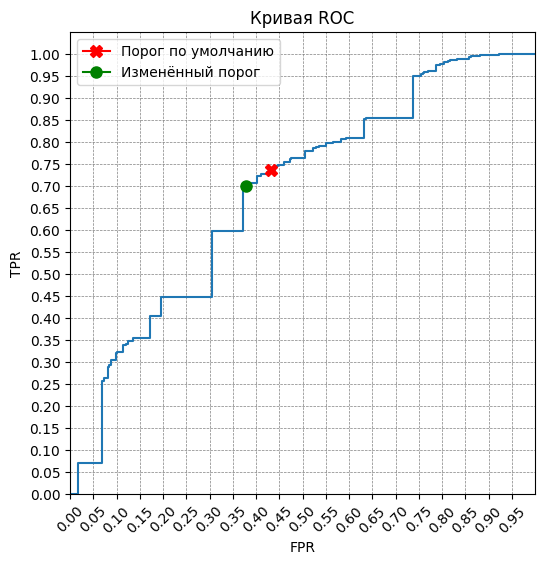

In [64]:
# Построим кривую ROC и отметим точку, соответствующую обученной модели
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xticks(np.arange(0, 1.0, step=0.05), rotation=45)
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--')
plt.title('Кривая ROC')
plt.plot(fpr_test, tpr_test, color='red', marker='X', markersize=8, label='Порог по умолчанию')
plt.plot(fpr[thresholds==thresholds[tpr>=0.7][0]],
    tpr[thresholds==thresholds[tpr>=0.7][0]], color='green', marker='o', markersize=8, label='Изменённый порог')
plt.legend()
plt.show()

Есть возможность, изменив порог модели по умолчанию, несколько уменьшив долю правильных предсказаний "ненадёжных" клиентов на 0,04 (до 0,7), уменьшить долю ошибочных предложений "надёжным" клиентам оплатить депозит на 0,06 до 0,37, что позволит увеличить прибыль в пессимистичном сценарии. В дальнейшем сравним два варианта.

In [65]:
# Требуемое значение порога, чтоб значение TPR было не ниже 0,7
th_tpr_70 = thresholds[tpr>=0.71][0]
predicted_forest_th_tpr_70 = (probabilities_one_test>th_tpr_70).astype('int')

# проверрим правильность выбранног порога
tn_th_tpr_70, fp_th_tpr_70, fn_th_tpr_70, tp_th_tpr_70 = confusion_matrix(target_test, predicted_forest_th_tpr_70).ravel()
tpr_th_tpr_70 = tp_th_tpr_70/(tp_th_tpr_70 + fn_th_tpr_70)
fpr_th_tpr_70 = fp_th_tpr_70/(fp_th_tpr_70 + tn_th_tpr_70)
print('TPR:', round(tpr_th_tpr_70, 3), 'FPR:', round(fpr_th_tpr_70, 3))

TPR: 0.707 FPR: 0.388


In [66]:
# Для сравнения посчитаем метрики случайной модели, которая прогнозирует отменуответы примерно в том же соотношении,
# что и в исходной выборке
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(features_train_ohe_scaled, target_train)
tn_dummy, fp_dummy, fn_dummy, tp_dummy = confusion_matrix(target_test,
                                                         dummy_model.predict(features_test_ohe_scaled)).ravel()
tpr_dummy = tp_dummy/(tp_dummy + fn_dummy)
fpr_dummy = fp_dummy/(fp_dummy + tn_dummy)
print('TPR:', round(tpr_dummy, 3), 'FPR:', round(fpr_dummy, 3))

TPR: 0.247 FPR: 0.255


Значения случайной модели существенно хуже, чем у полученной нами ранее.

### Оценка прибыли от внедрения модели

In [67]:
# Вычислим прибыль после внедрения депозитов для двух вариантов порога модели
# Вариант с порогом по умолчанию
test['forecast'] = predicted_forest_test
test['earnings'] = test.apply(earnings, is_deposit=1, axis=1)
earning_default_th_optimistic = test['earnings'].sum()
profit_default_th_optimistic = 1e-6*(earning_default_th_optimistic - earning_before_deposit)
earning_default_th_pessimistic = earning_default_th_optimistic - test[test['forecast']==1].\
                                          sample(random_state=RANDOM_STATE, frac=0.5)['earnings'].sum()
profit_default_th_pessimistic = 1e-6*(earning_default_th_pessimistic - earning_before_deposit)

# Вариант с изменённым порогом
test['forecast'] = predicted_forest_th_tpr_70
test['earnings'] = test.apply(earnings, is_deposit=1, axis=1)
earning_th_trp_70_optimistic = test['earnings'].sum()
profit_th_trp_70_optimistic = 1e-6*(earning_th_trp_70_optimistic - earning_before_deposit)
earning_th_trp_70_pessimistic = earning_th_trp_70_optimistic - test[test['forecast']==1].\
                                          sample(random_state=RANDOM_STATE, frac=0.5)['earnings'].sum()
profit_th_trp_70_pessimistic = 1e-6*(earning_th_trp_70_pessimistic - earning_before_deposit)
results_test.loc[results_test['Модель'] == 'Случайный лес на тесте', 'Оптимистичный базовый, млн'] =\
                                                                      profit_default_th_optimistic
results_test.loc[results_test['Модель'] == 'Случайный лес на тесте', 'Пессимистичный базовый, млн'] =\
                                                                      profit_default_th_pessimistic
results_test.loc[results_test['Модель'] == 'Случайный лес на тесте', 'Оптимистичный с подбором порога, млн'] =\
                                                                      profit_th_trp_70_optimistic
results_test.loc[results_test['Модель'] == 'Случайный лес на тесте', 'Пессимистичный с подбором порога, млн'] =\
                                                                      profit_th_trp_70_pessimistic
results_test

,Модель,HP_1,HP_2,HP_3,TPR_test,FPR_test,AUC_ROC_test,"Оптимистичный базовый, млн","Пессимистичный базовый, млн","Оптимистичный с подбором порога, млн","Пессимистичный с подбором порога, млн"
0,Случайный лес на тесте,min_samples_split: 0.4,max_depth: 4,n_estimators: 10,0.736496,0.432881,0.709643,5.2446,-4.68875,5.02168,-4.00119


Прибыль в оптимистичном варианте составит 5-5,25 млн, при этом в пессимистичном сценарии может быть убыток (очень жёстком, предполагающем отказ половины гостей, которым предложено оплатить депозит, от бронирования).

## Шаг 5. Портрет «ненадёжного» клиента

По данным исследовательского анализа данных можно заключить, что "ненадёжный" клиент:
- рассматривает варианты на троих взрослых или с 2-3 детьми от 3 до 14 лет,
- бронирует на 6,8,10 ночей, с захватом 2-4 выходнях и 4-6 будних дней, в период с апреля по август, при этом даты бронирования ближе к концу месяца,
- является гражданином Португалии или Италии,
- не связан с договором или групповым заездом,
- заказ оформляет по каналу дистрибуции TA/TO,
- ранее уже отменял заказы, а в текущем заказе не сделал никаких изменений,
- бронирует за 50 дней и раньше до прибытия,
- выбирает тип питания SC или FB, номер категории G, парковку и другие специальные опции не требует.

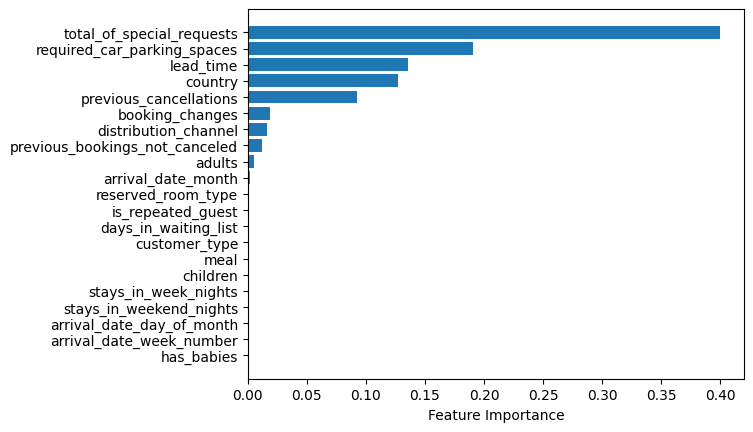

In [68]:
# Проверим важность признаков с точки зрения модели
sort = model.feature_importances_.argsort()
plt.barh(features_test_ordinal.columns[sort], model.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.show()

Как видим, многие параметры, которые удалось выявить в качестве маркеров "ненадёжного" клиента на этапе исследовательского анализа данных, в модели имеют высокий вес.

## Шаг 6. Общий вывод

В ходе исследования была разработана модель, предсказывающая отмену бронирования клиентом отеля, что позволяет увеличить прибыль отеля на 5-5,25 млн за 8 месяцев.
Поскольку доля ошибочных предложений оплатить депозит составляет более 30%, необходимо заказчику обратить внимание, как влияет необходимость оплаты депозита на клиентов. Если число неподтверждённых заказов станет увеличиваться, то не исключено уменьшение прибыли за счёт оттока клиентов.

В рамках разработки модели было выполнено:
- загрузка и предобработка данных,
- исследовательский анализ данных, с описание портрета "ненадёжного" клиента,
- кодирование и масштабирование признаков для обучения моделей машинного обучения,
- обучение различных моделей, подбор гиперпараметров, выбор наиболее подходящей моддели с точки зрения увеличения прибыли отеля.